### **DATASET INFORMATION**



In [12]:
import pandas as pd

def get_dataset_info(test_file, label_file):
    print(f"\nDataset Information for {test_file} and {label_file}:")

    # Read test and label files
    test_data = pd.read_csv(test_file)
    label_data = pd.read_csv(label_file)

    # Print basic information about the test data
    print("\nTest Data:")
    print(f"Shape: {test_data.shape}")
    print(f"Columns: {list(test_data.columns)}")
    print(f"Data types:\n{test_data.dtypes}")

    # Print basic information about the label data
    print("\nLabel Data:")
    print(f"Shape: {label_data.shape}")
    print(f"Columns: {list(label_data.columns)}")
    print(f"Data types:\n{label_data.dtypes}")

    # Print summary statistics for the test data
    print("\nTest Data Summary Statistics:")
    print(test_data.describe())

    # Print unique values and counts for the label data
    print("\nLabel Data Unique Values and Counts:")
    for column in label_data.columns:
        print(f"{column}:")
        print(label_data[column].value_counts())
        print()

# Main function
if __name__ == "__main__":
    # List of file sets
    file_sets = [
        ("test.csv", "test_label.csv"),
        ("smap_test.csv", "smap_test_label.csv"),
        ("msl_test.csv", "msl_test_label.csv"),
        ("psm_test.csv", "psm_test_label.csv")
    ]

    # Iterate through each file set
    for test_file, label_file in file_sets:
        get_dataset_info(test_file, label_file)


Dataset Information for test.csv and test_label.csv:

Test Data:
Shape: (70001, 38)
Columns: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37']
Data types:
0     float64
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
13    float64
14    float64
15    float64
16    float64
17    float64
18    float64
19    float64
20    float64
21    float64
22    float64
23    float64
24    float64
25    float64
26    float64
27    float64
28    float64
29    float64
30    float64
31    float64
32    float64
33    float64
34    float64
35    float64
36    float64
37    float64
dtype: object

Label Data:
Shape: (70001, 1)
Columns: ['0']
Data types:
0    int64
dtype: object

Test Data Summary Statistics:
               

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor

def read_files(test_file, label_file=None):
    test_data = pd.read_csv(test_file)
    label_data = None
    if label_file:
        label_data = pd.read_csv(label_file)
    return test_data, label_data

def plot_time_series(test_data, label_data=None, anomaly_indices=None, time_column='timestamp_(min)', downsample_factor=2000):
    if time_column in test_data.columns:
        downsampled_data = test_data.iloc[::downsample_factor, :]
        plt.figure(figsize=(10, 6))
        plt.plot(downsampled_data[time_column], downsampled_data.drop(time_column, axis=1).values, label='Time Series Data')
    else:
        downsampled_data = test_data.iloc[::downsample_factor, :]
        plt.figure(figsize=(10, 6))
        plt.plot(downsampled_data.index, downsampled_data.values, label='Time Series Data')

    if label_data is not None:
        if 'start_time' in label_data.columns and 'end_time' in label_data.columns:
            for _, anomaly in label_data.iterrows():
                plt.axvspan(anomaly['start_time'], anomaly['end_time'], color='red', alpha=0.3, label='Anomaly Region')
        elif 'label' in label_data.columns and anomaly_indices is not None:
            for start, end in zip(anomaly_indices, anomaly_indices[1:]):
                plt.axvspan(start, end, color='red', alpha=0.3, label='Anomaly Region')

    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Time Series Data with Anomaly Regions')
    plt.legend()
    plt.savefig('time_series_plot.svg', format='svg', bbox_inches='tight')
    plt.close()

def detect_anomalies(test_data, method='local_outlier_factor'):
    if method == 'local_outlier_factor':
        lof = LocalOutlierFactor(contamination=0.1)
        anomalies = lof.fit_predict(test_data)
        anomaly_indices = np.where(anomalies == -1)[0]
        return anomaly_indices
    # Add other anomaly detection methods here
    else:
        raise ValueError("Unsupported anomaly detection method.")

def perform_eda(test_data):
    for column in test_data.columns:
        plt.figure(figsize=(8, 4))
        plt.hist(test_data[column], bins=20)
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

    plt.figure(figsize=(10, 8))
    correlation_matrix = test_data.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(test_data)
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA Visualization')
    plt.show()

    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans.fit(test_data)
    plt.figure(figsize=(8, 6))
    plt.scatter(test_data.iloc[:, 0], test_data.iloc[:, 1], c=kmeans.labels_, cmap='viridis')
    plt.xlabel(test_data.columns[0])
    plt.ylabel(test_data.columns[1])
    plt.title('K-Means Clustering')
    plt.show()

def find_root_cause(test_data, anomaly_indices):
    X = test_data.copy()
    X['anomaly'] = False
    X.iloc[anomaly_indices, -1] = True
    
    y = X.pop('anomaly')

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)

    importances = permutation_importance(rf, X, y)
    feature_importances = pd.Series(importances.importances_mean, index=X.columns)
    print("\nFeature importances:")
    print(feature_importances.sort_values(ascending=False))

def process_file(test_file, label_file):
    test_data, label_data = read_files(test_file, label_file)
    time_column = 'timestamp_(min)' if 'timestamp_(min)' in test_data.columns else None
    anomaly_indices = detect_anomalies(test_data.drop(columns=[time_column], errors='ignore') if time_column else test_data)

    plot_time_series(test_data, label_data=label_data, anomaly_indices=anomaly_indices, time_column=time_column, downsample_factor=2000)
    perform_eda(test_data)
    find_root_cause(test_data, anomaly_indices)

In [3]:
def process_file(test_file, label_file):
    test_data, label_data = read_files(test_file, label_file)
    time_column = 'timestamp_(min)' if 'timestamp_(min)' in test_data.columns else None
    anomaly_indices = detect_anomalies(test_data.drop(columns=[time_column], errors='ignore') if time_column else test_data)

    plot_time_series(test_data, label_data=label_data, anomaly_indices=anomaly_indices, time_column=time_column, downsample_factor=2000)
    perform_eda(test_data)
    find_root_cause(test_data, anomaly_indices)

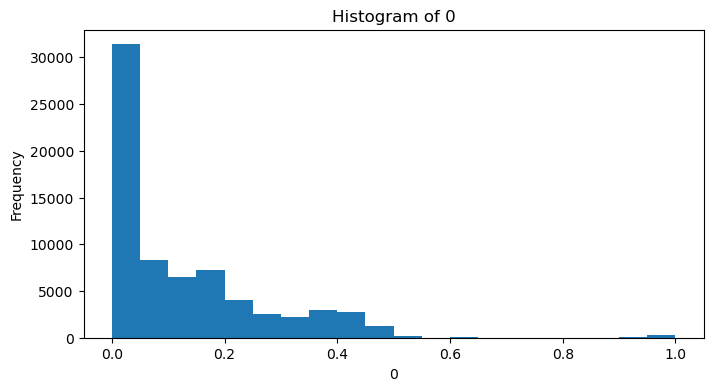

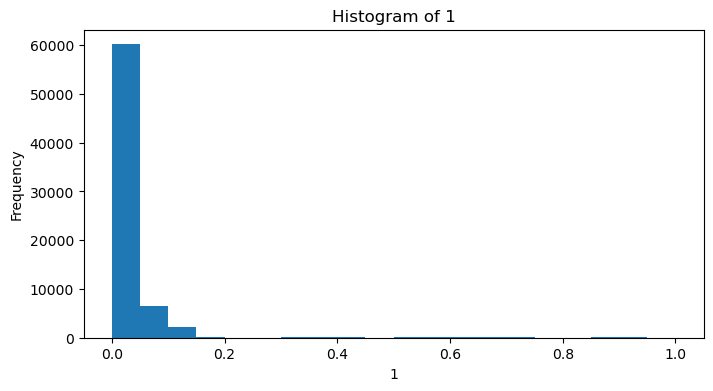

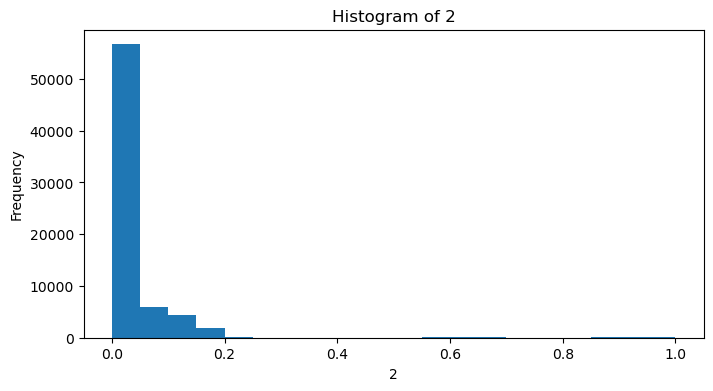

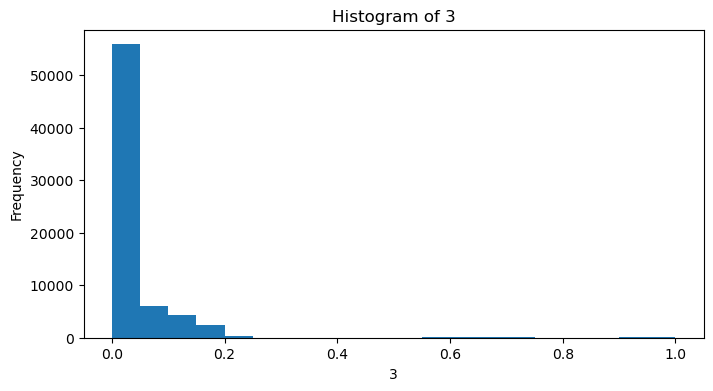

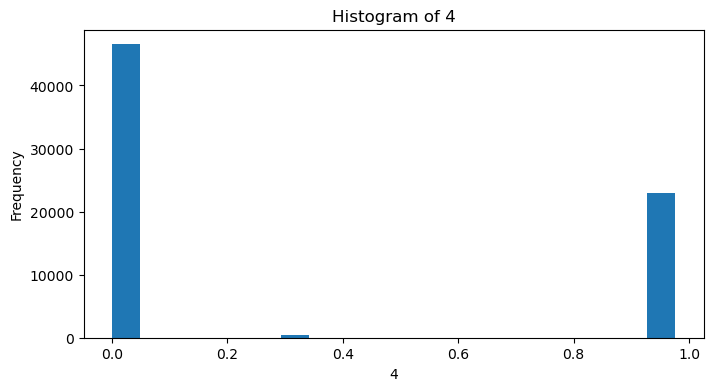

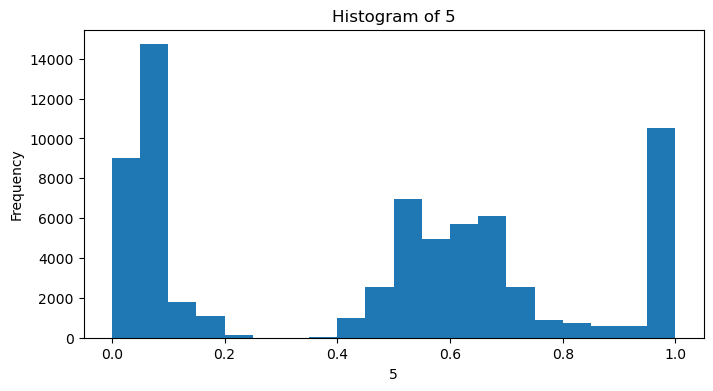

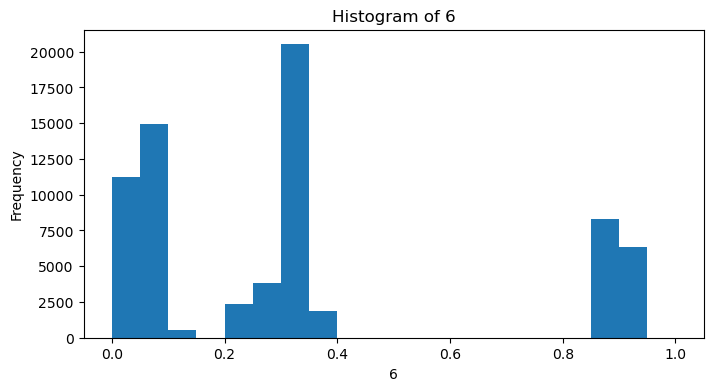

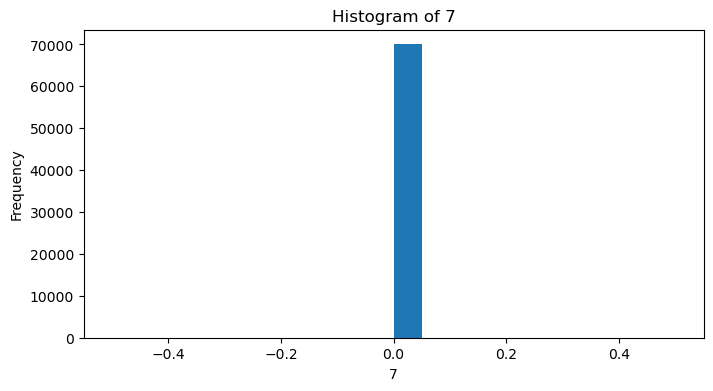

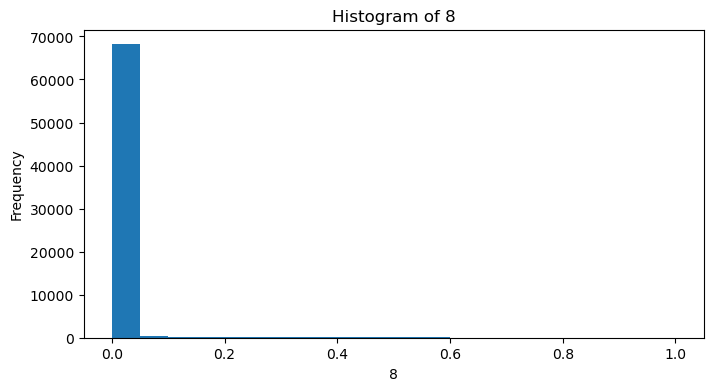

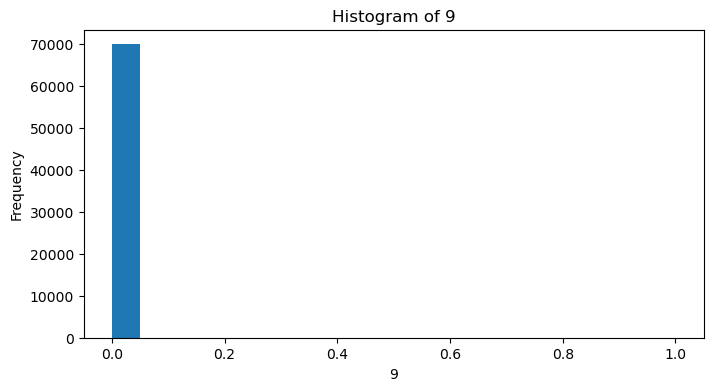

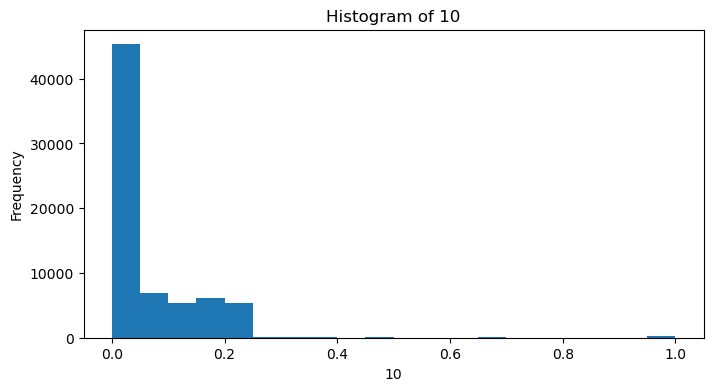

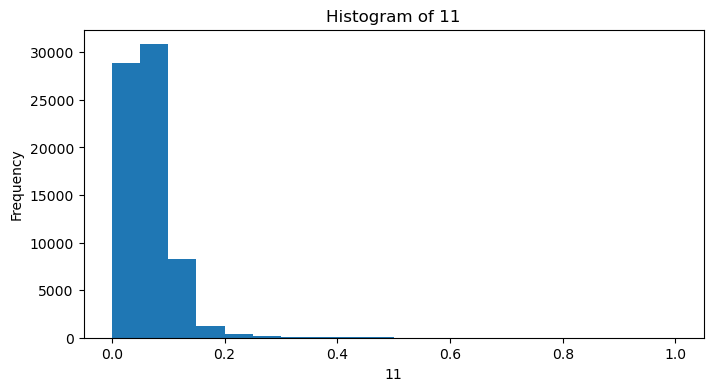

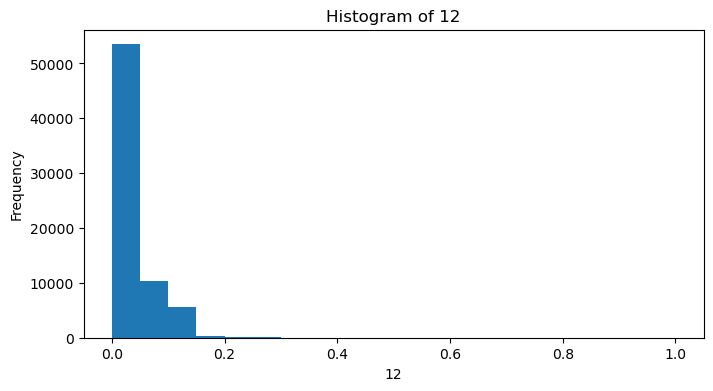

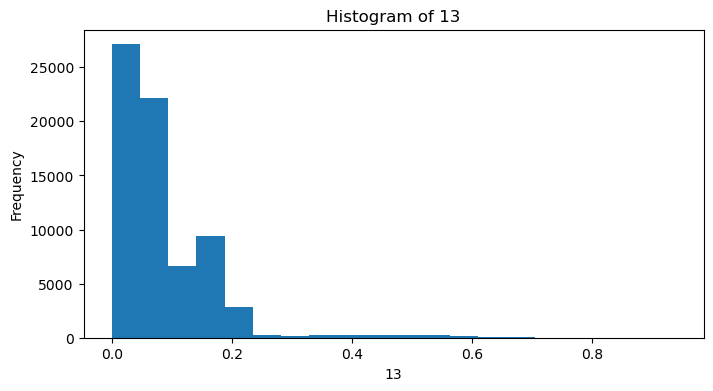

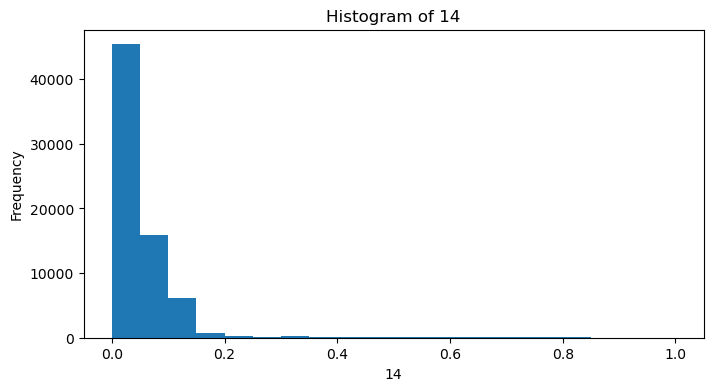

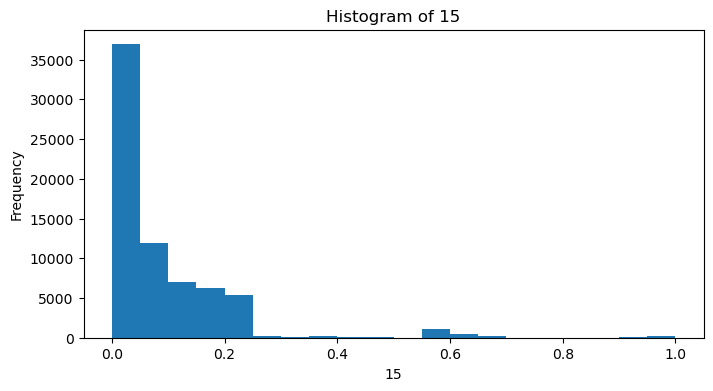

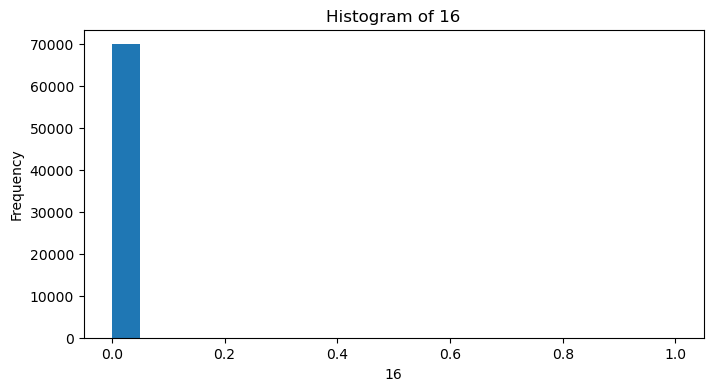

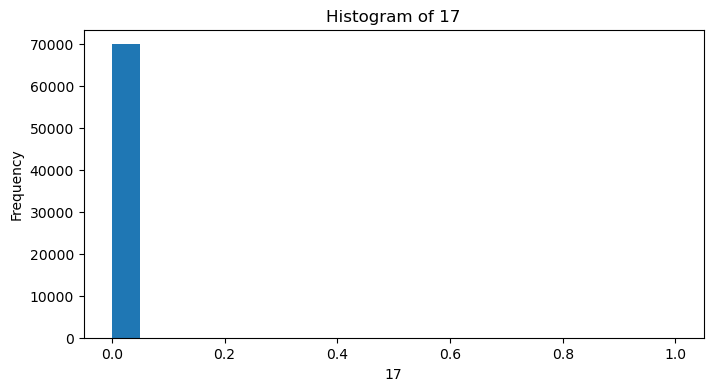

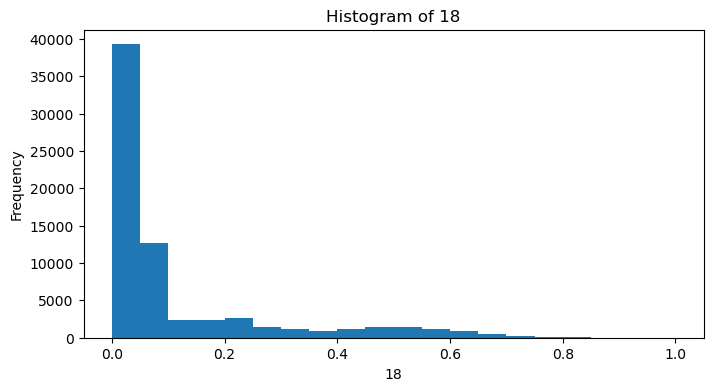

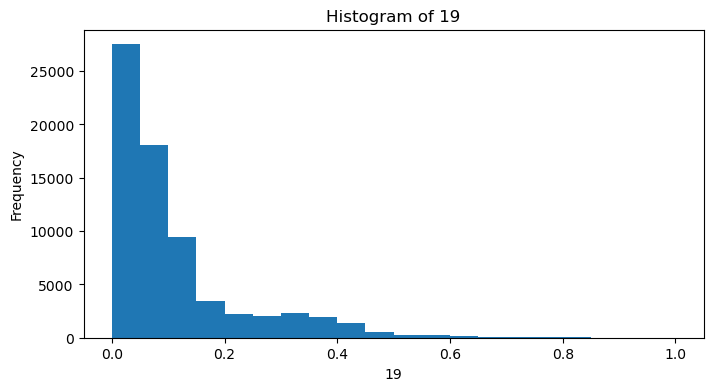

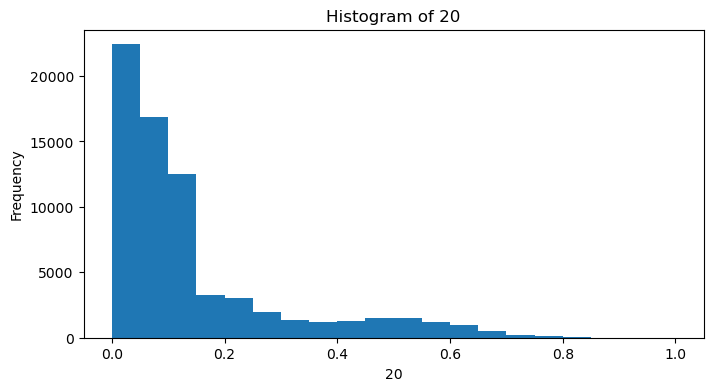

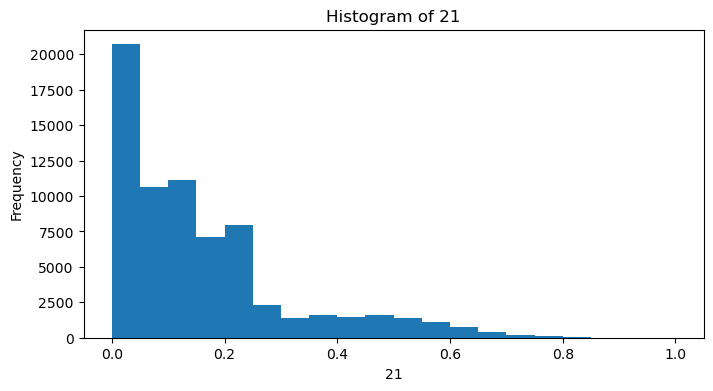

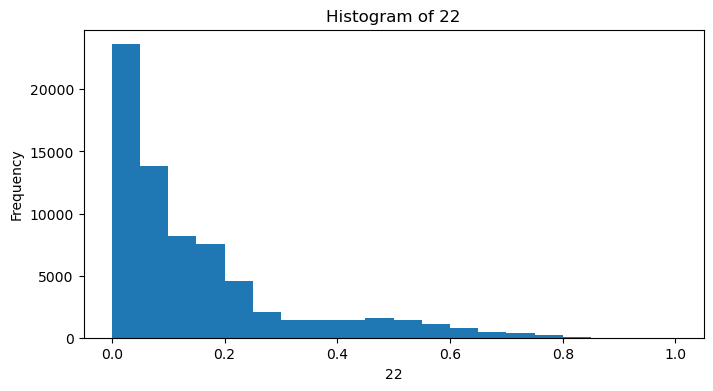

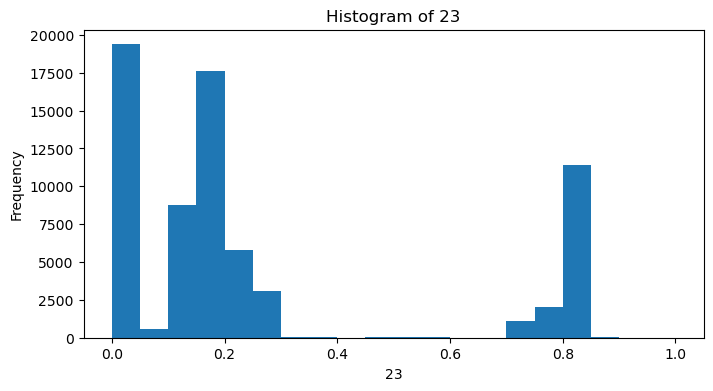

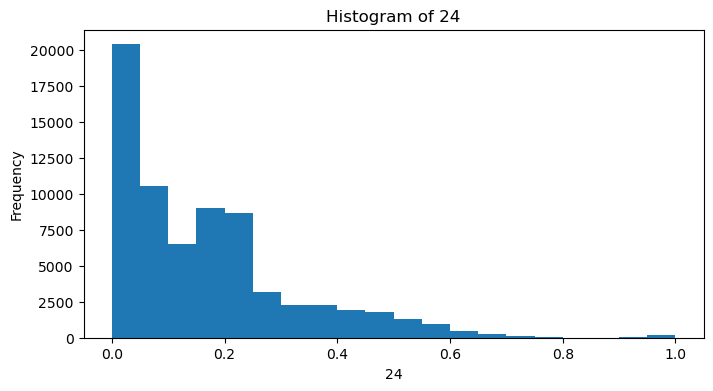

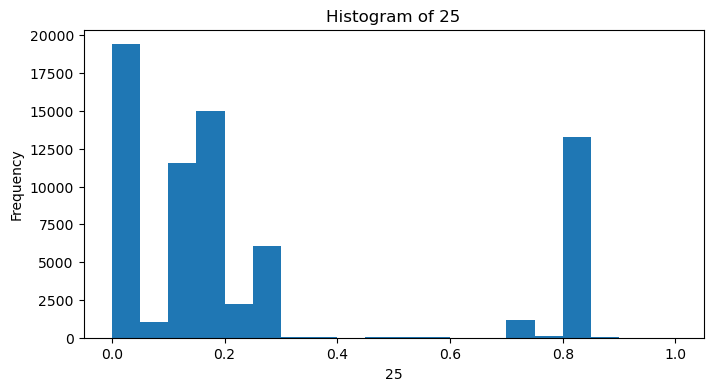

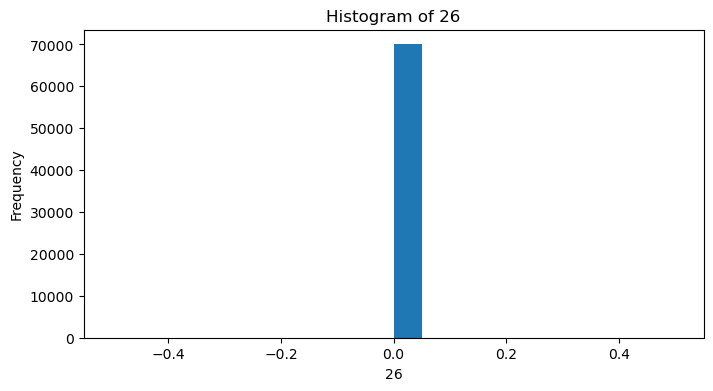

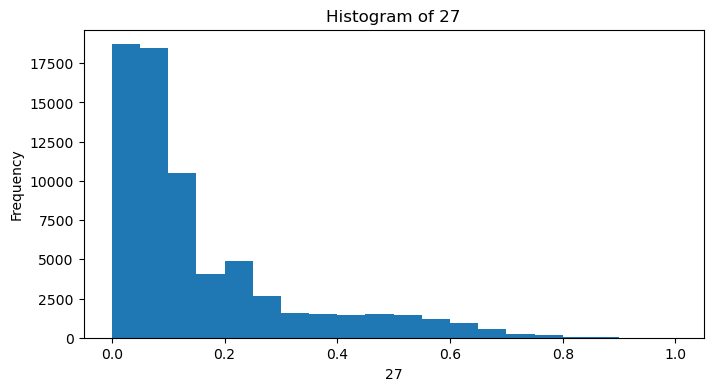

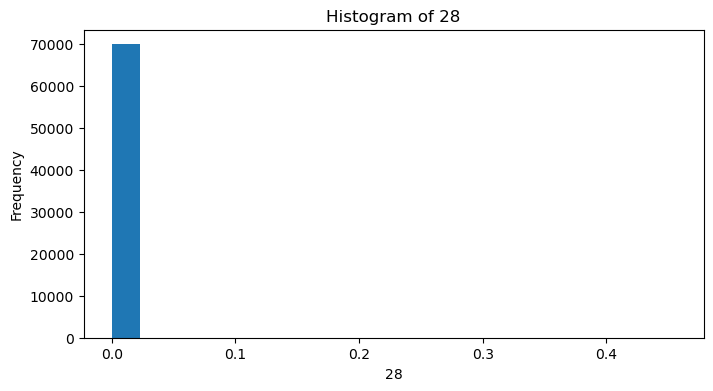

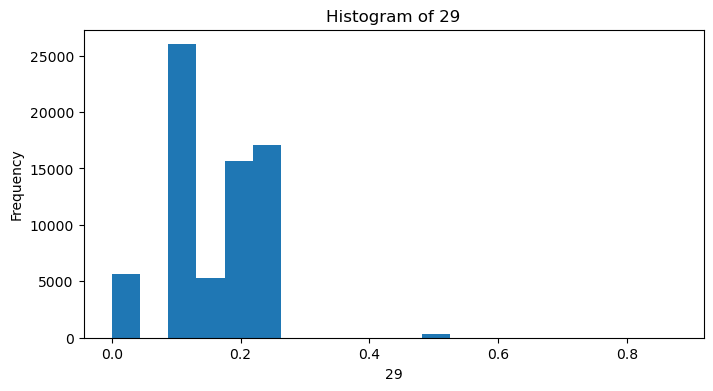

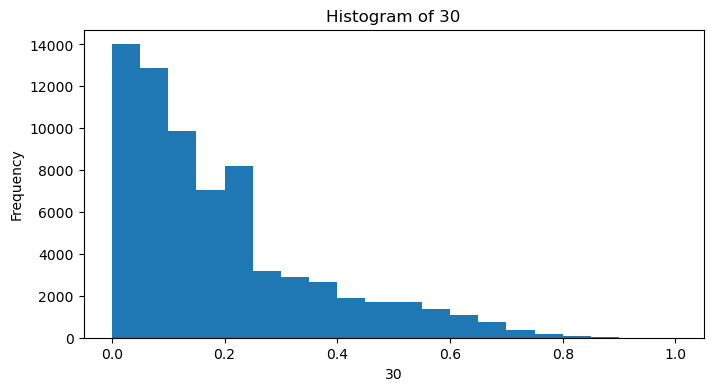

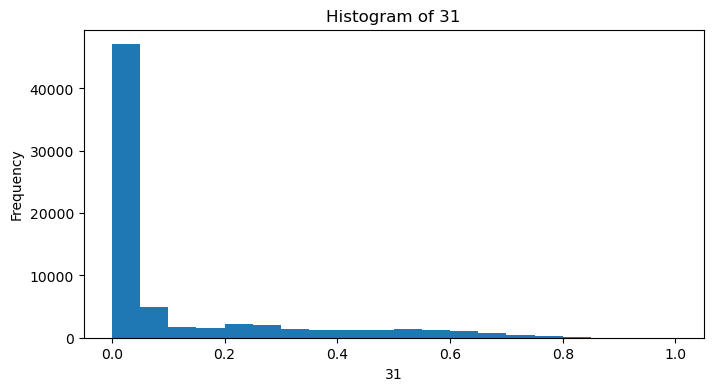

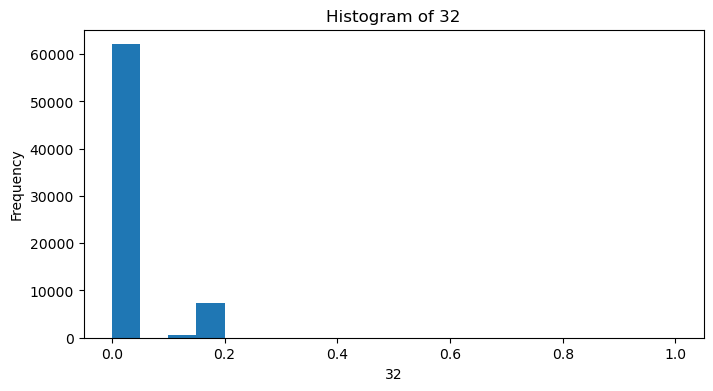

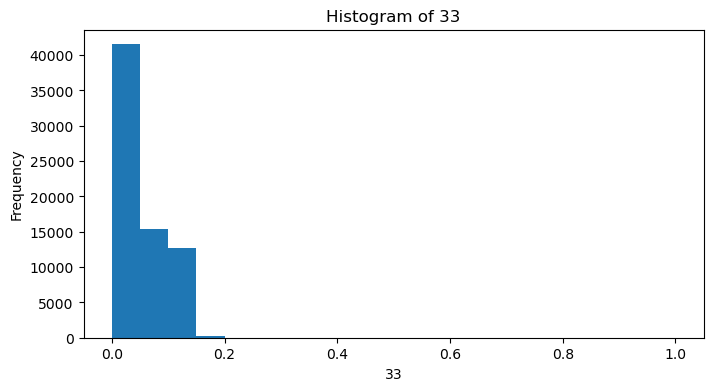

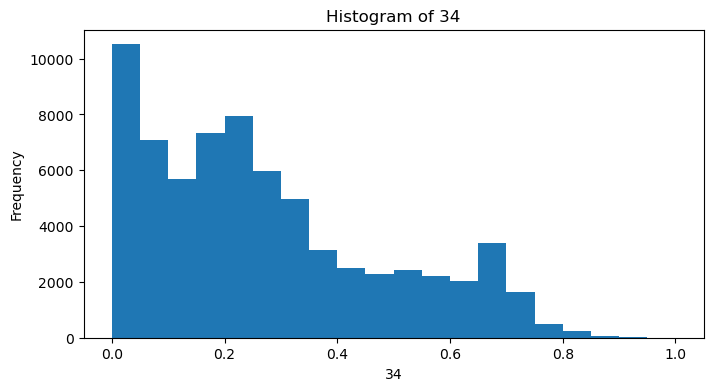

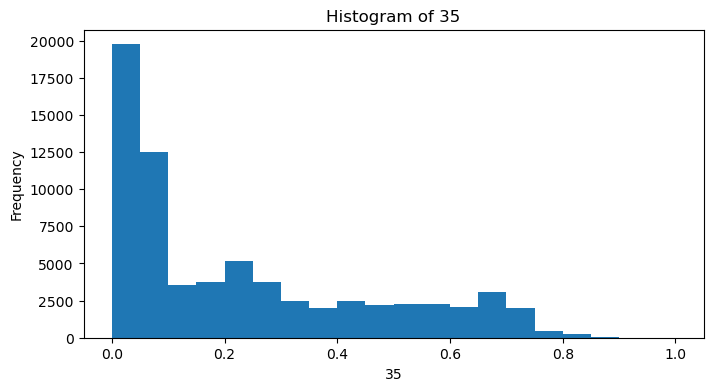

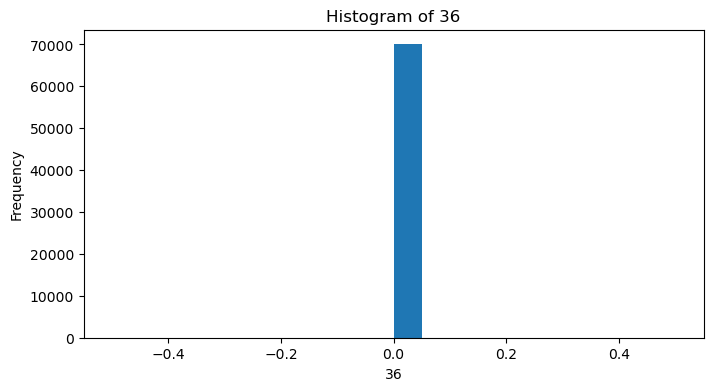

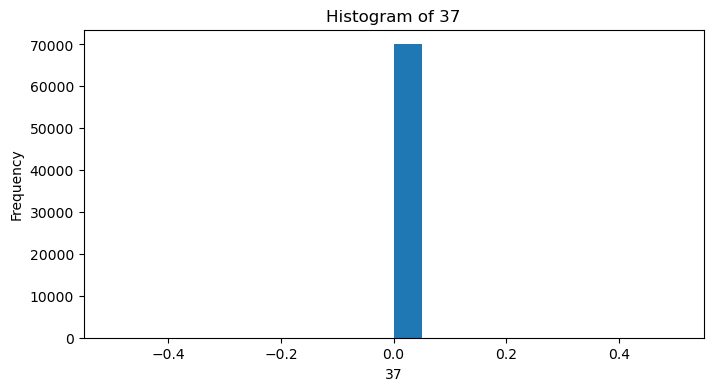

C:\Users\shiva\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


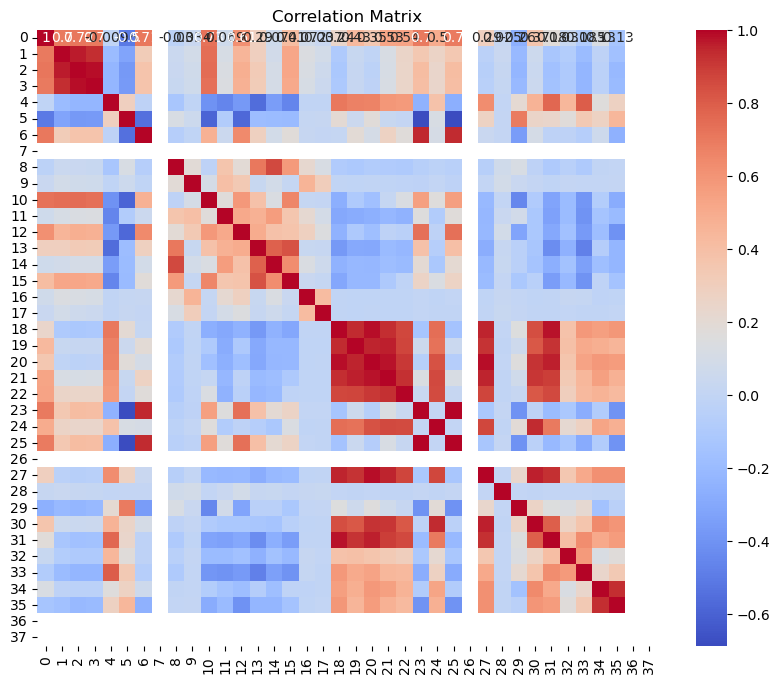

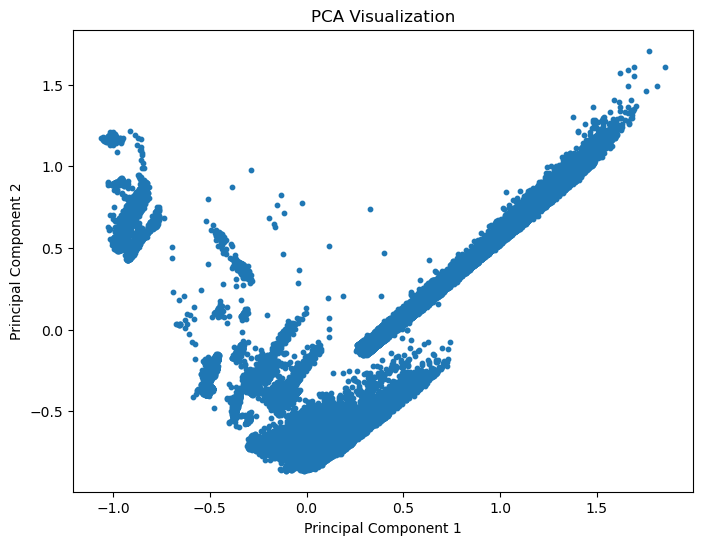

C:\Users\shiva\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


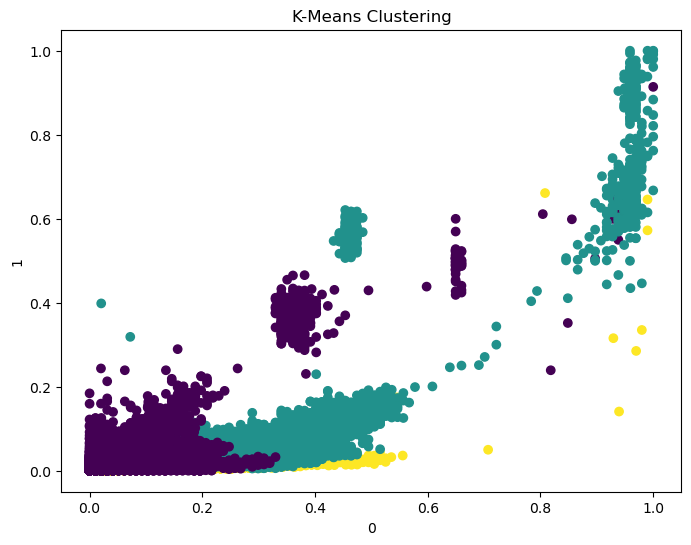


Feature importances:
19    1.065619
29    1.042047
6     0.978154
11    0.864119
13    0.840690
22    0.828951
33    0.787162
3     0.717778
15    0.709615
23    0.618413
18    0.579855
25    0.579445
1     0.579422
8     0.510513
35    0.485756
5     0.471011
14    0.458637
34    0.381154
31    0.285176
24    0.276857
2     0.268628
10    0.240784
0     0.218799
32    0.090331
30    0.085718
9     0.085222
21    0.079759
27    0.060504
20    0.043623
12    0.032186
4     0.003026
17    0.000682
16    0.000021
26    0.000000
28    0.000000
7     0.000000
36    0.000000
37    0.000000
dtype: float64


In [5]:
# 1.test.csv --> test_label.csv
process_file("test.csv", "test_label.csv")

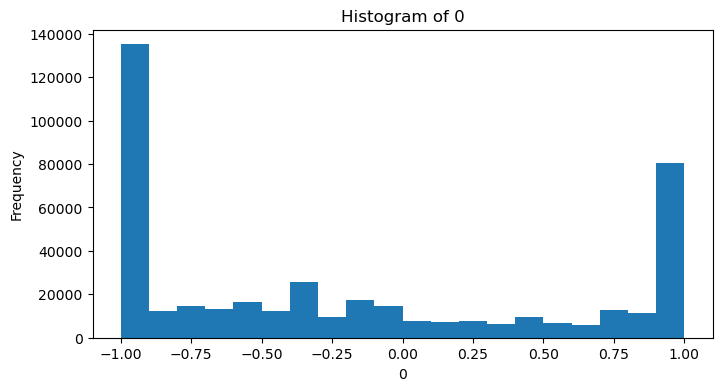

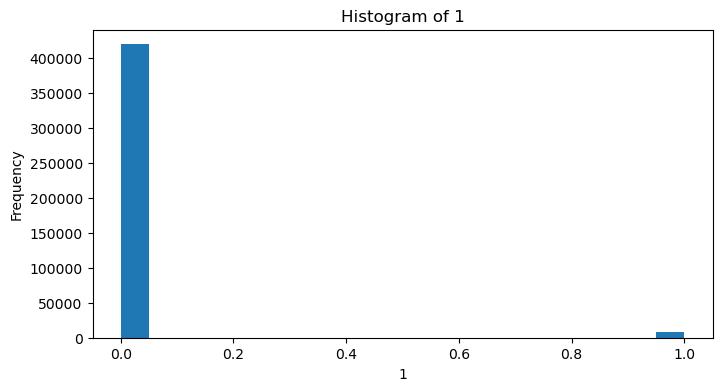

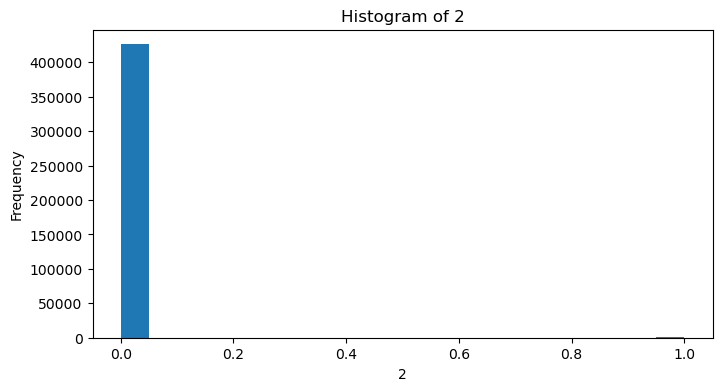

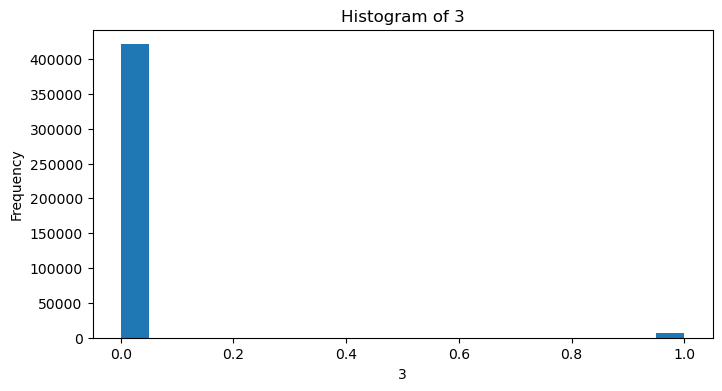

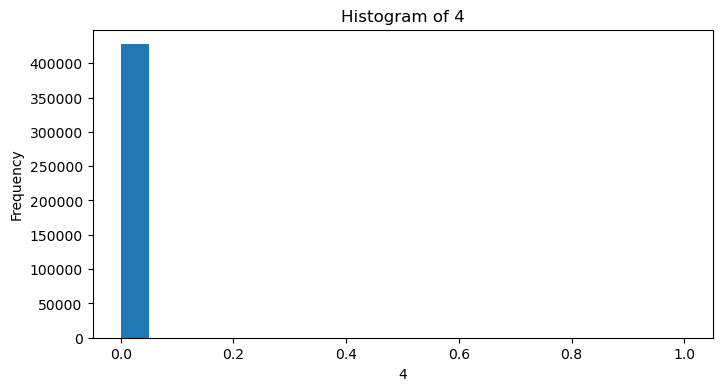

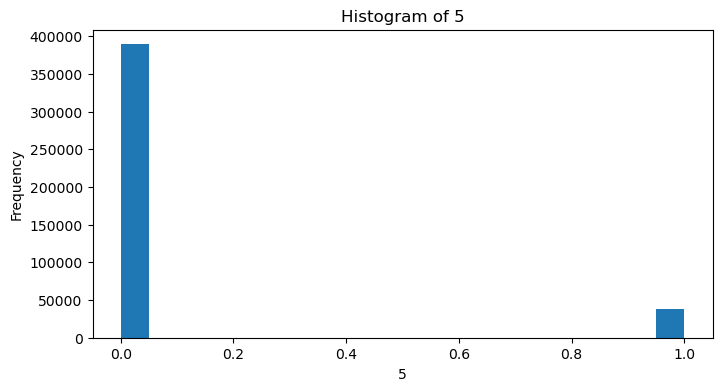

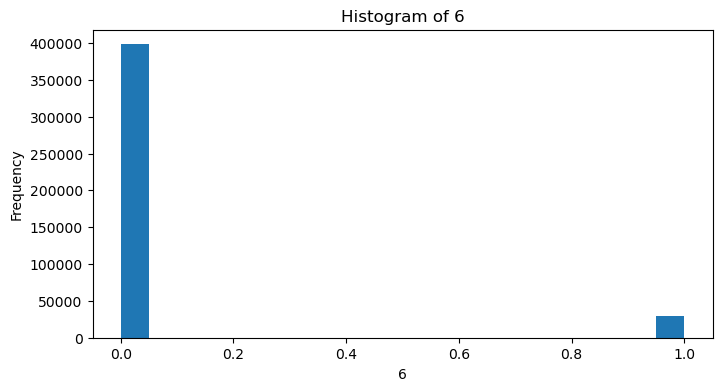

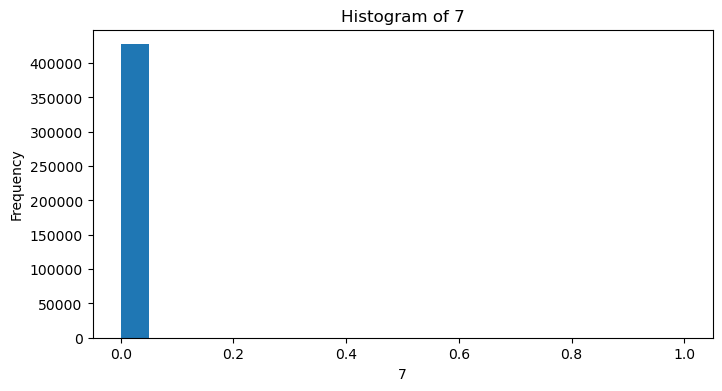

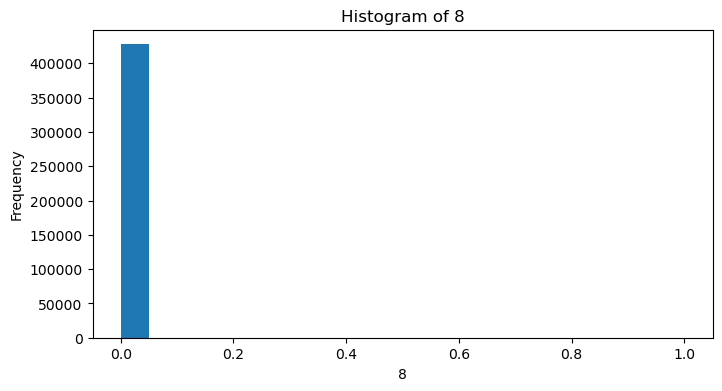

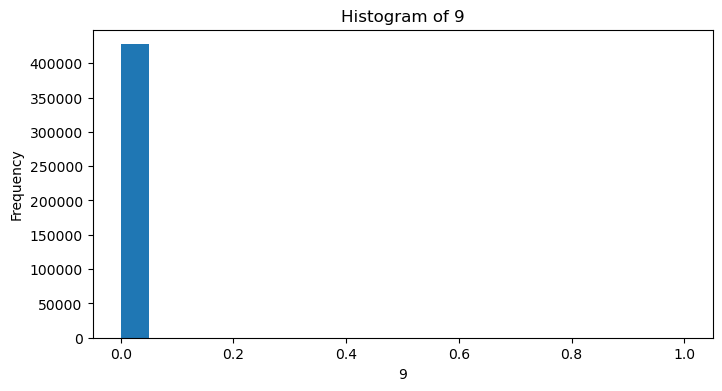

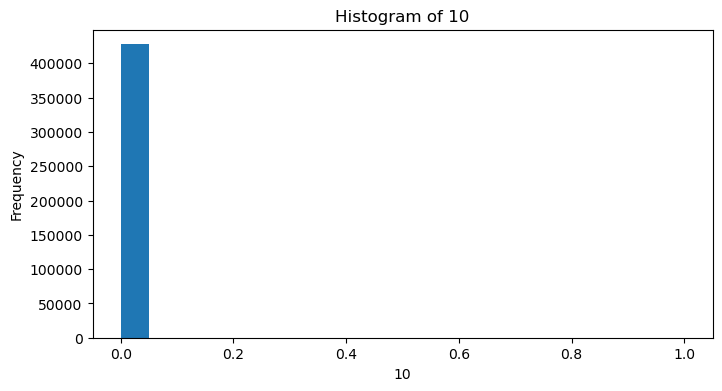

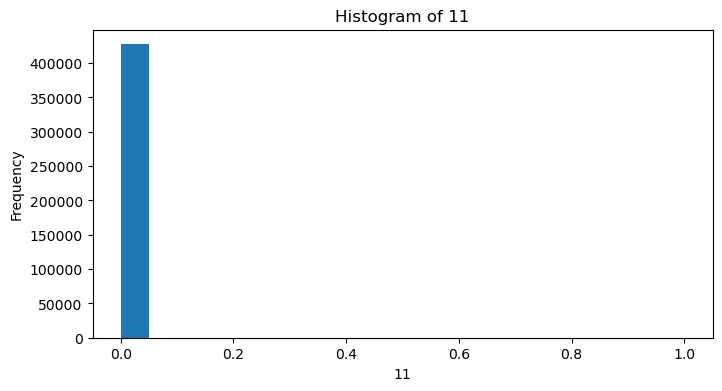

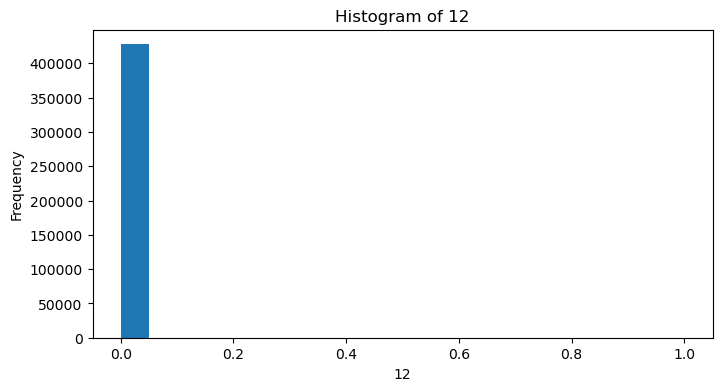

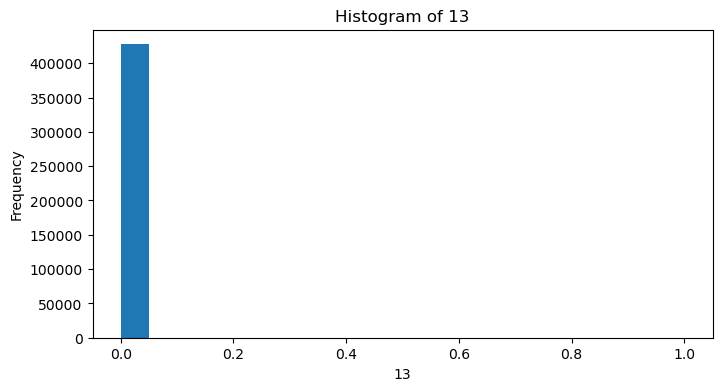

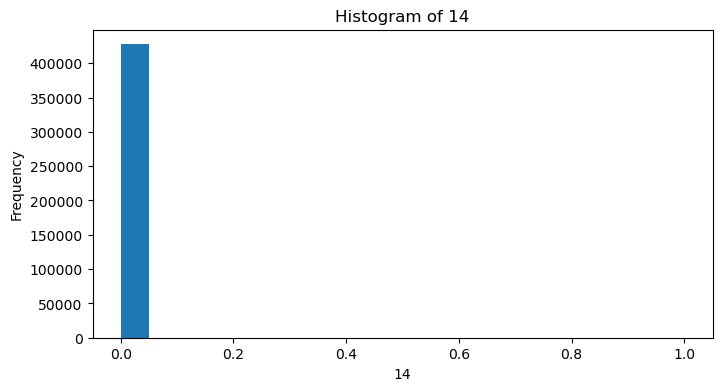

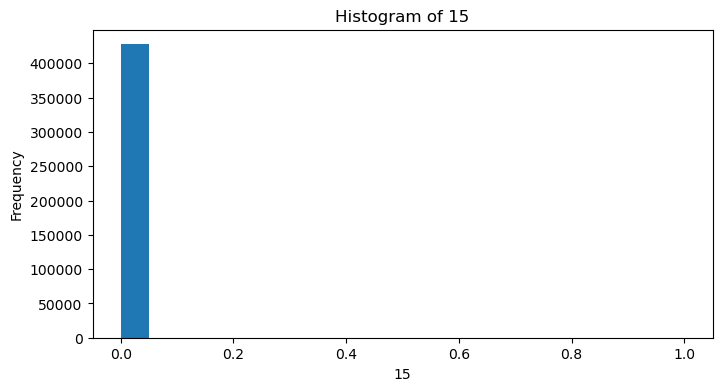

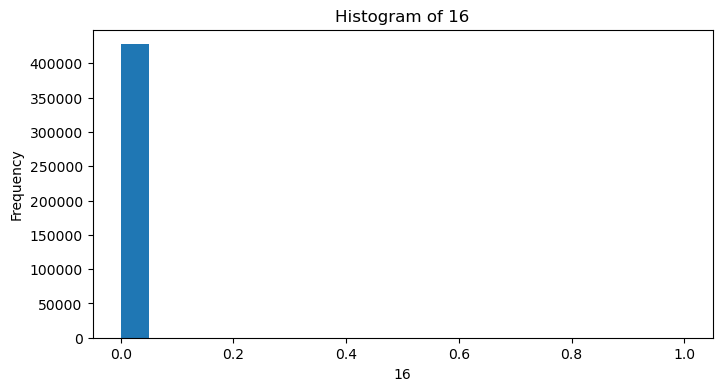

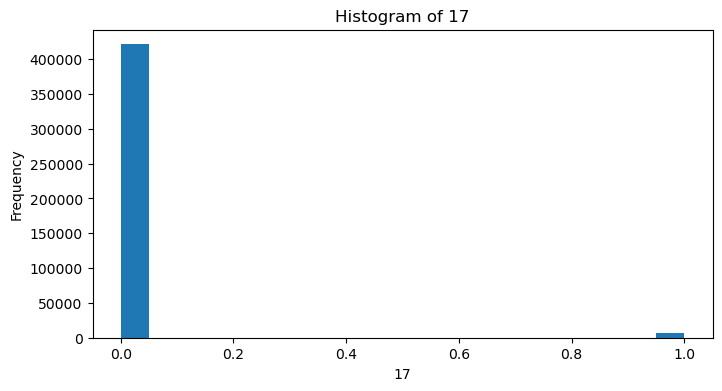

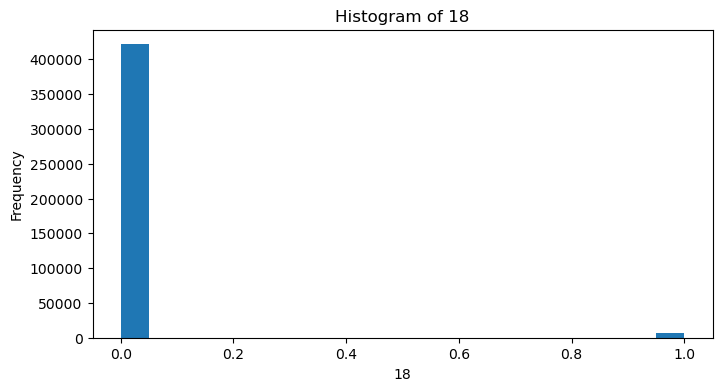

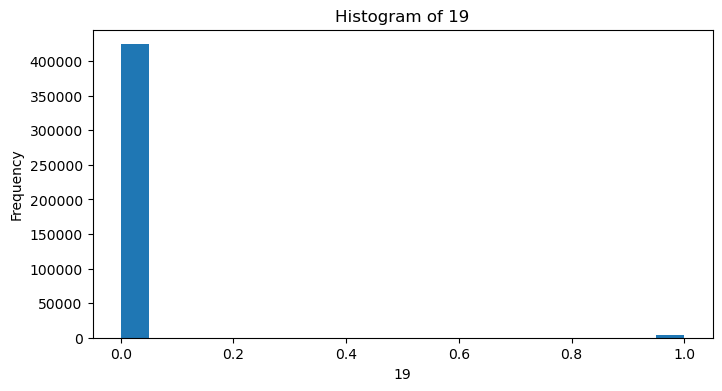

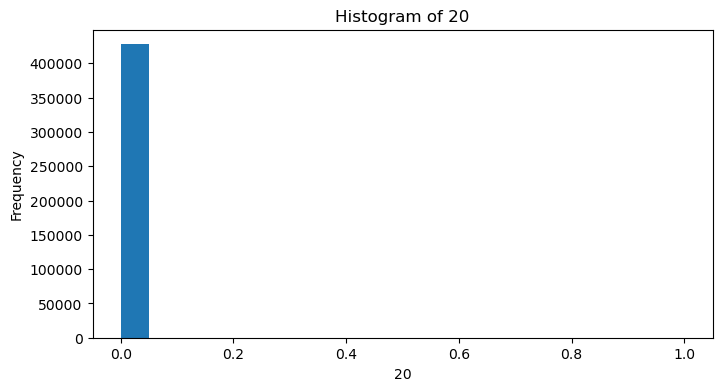

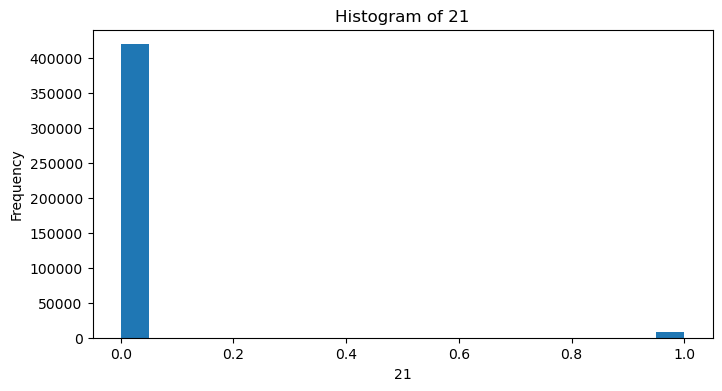

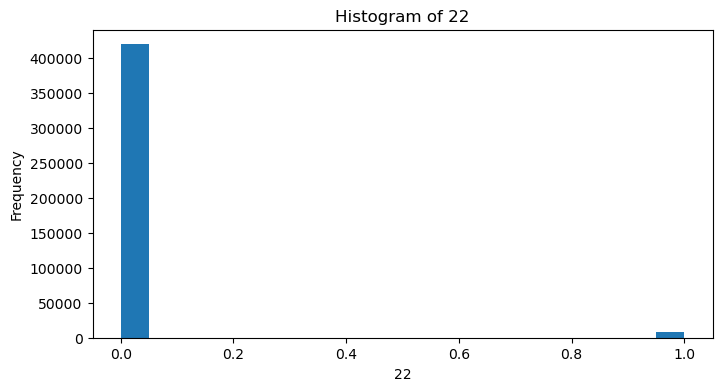

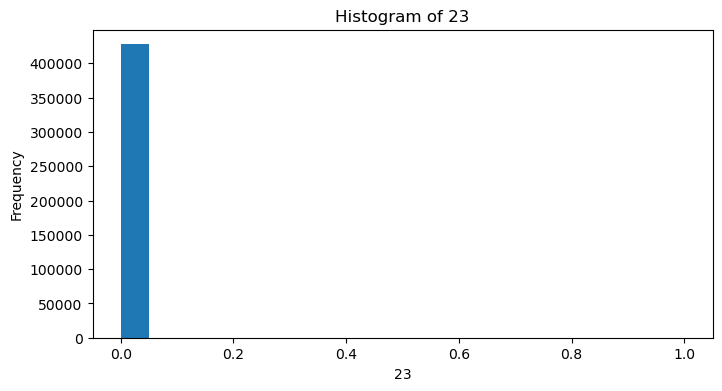

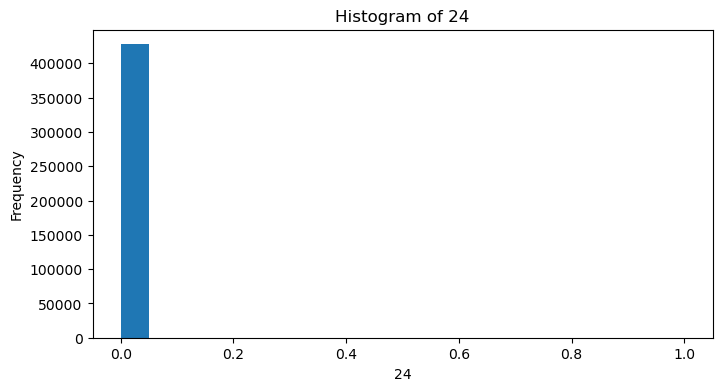

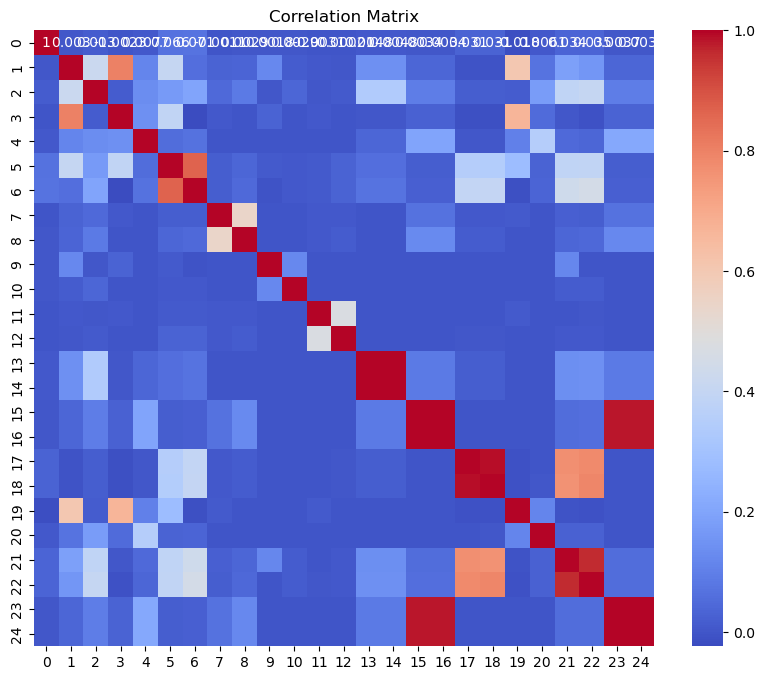

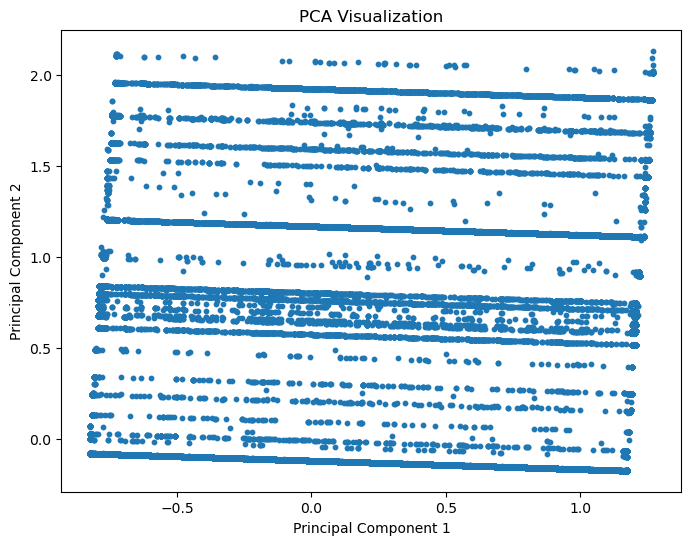

C:\Users\shiva\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


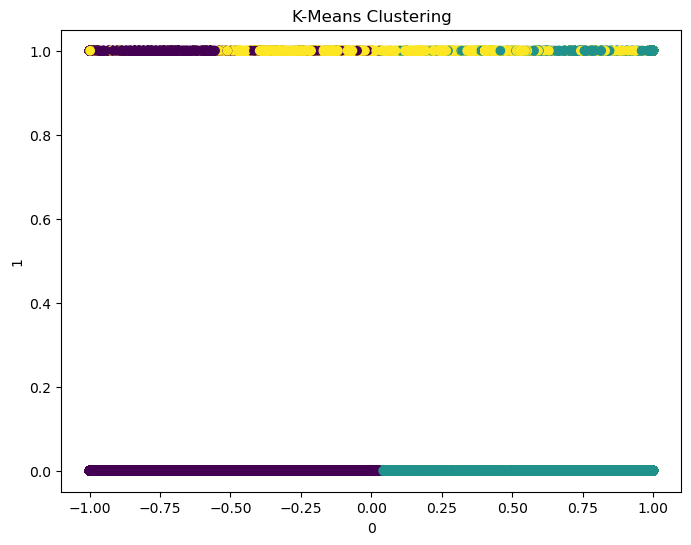


Feature importances:
0     1.968377
5     0.461473
6     0.235118
21    0.118106
3     0.099771
1     0.077031
17    0.062870
22    0.055451
18    0.025645
19    0.014327
2     0.005939
7     0.003574
11    0.003097
8     0.001024
20    0.000912
9     0.000889
4     0.000653
13    0.000471
14    0.000440
12    0.000305
24    0.000038
15    0.000035
16    0.000032
23    0.000029
10    0.000023
dtype: float64


In [6]:
# 2.smap_test.csv --> smap_test_labels.csv
process_file("smap_test.csv", "smap_test_label.csv")

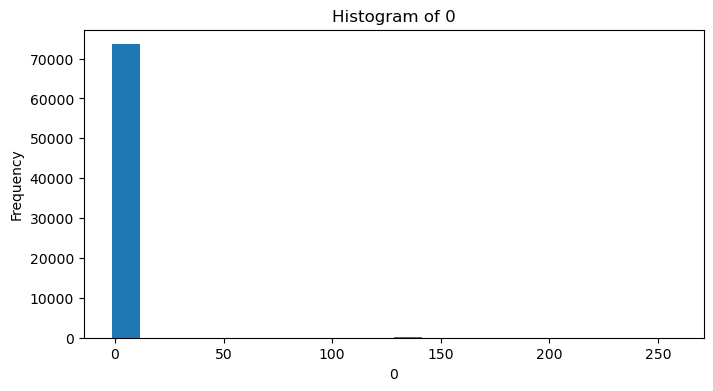

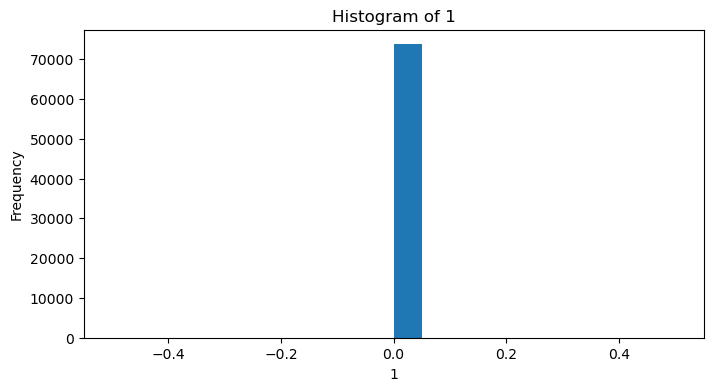

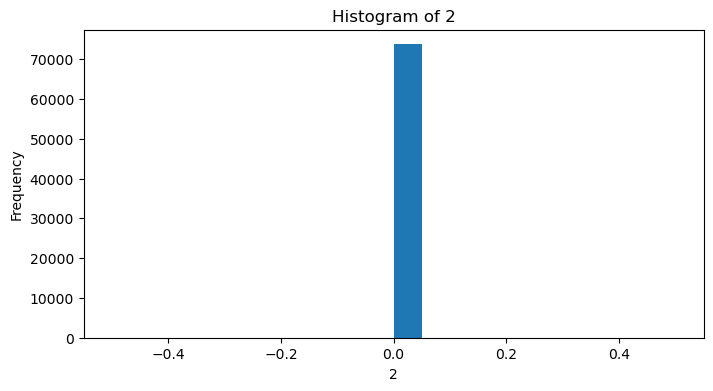

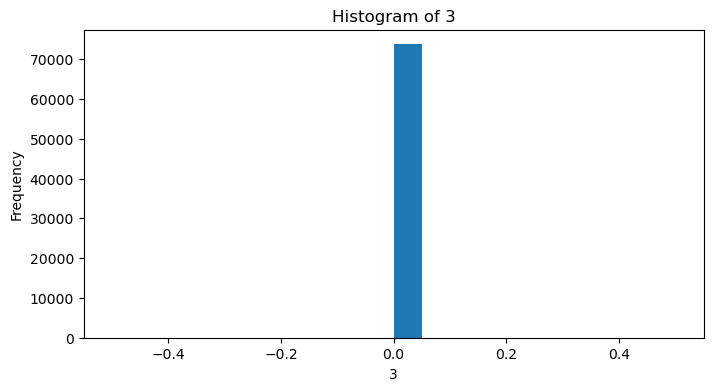

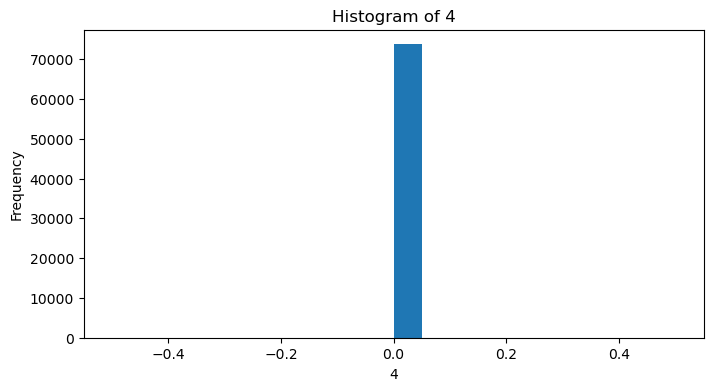

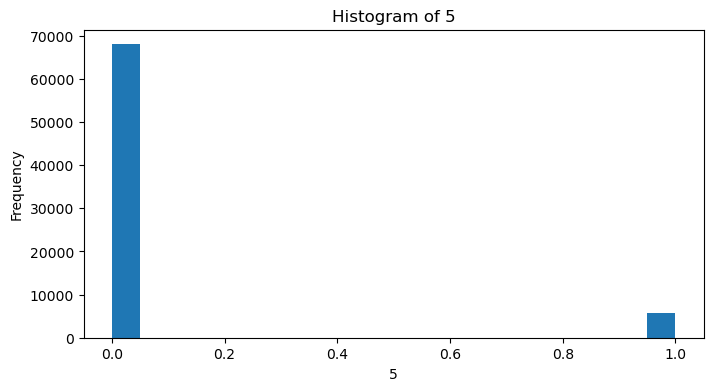

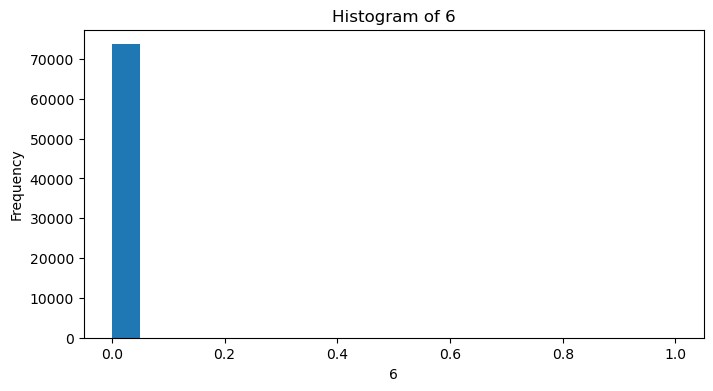

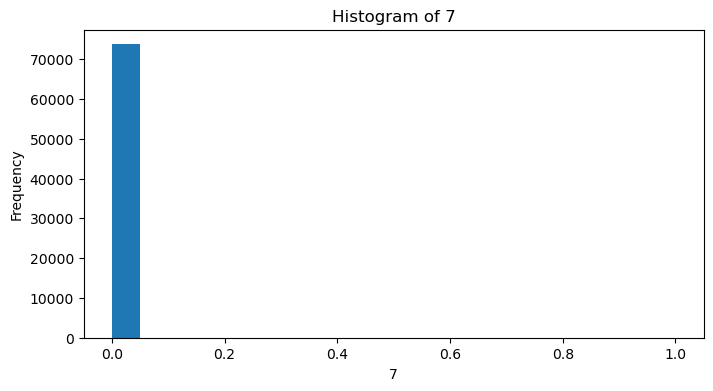

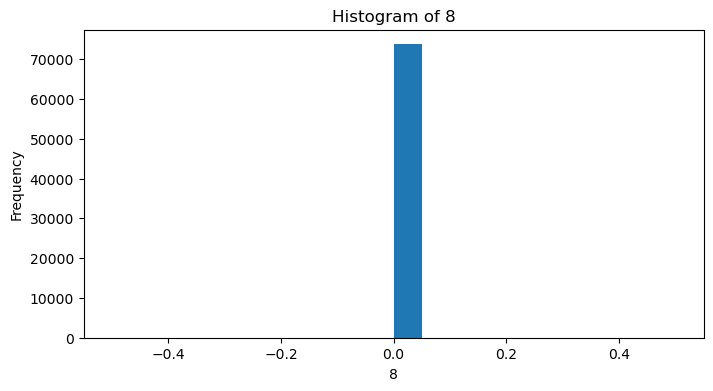

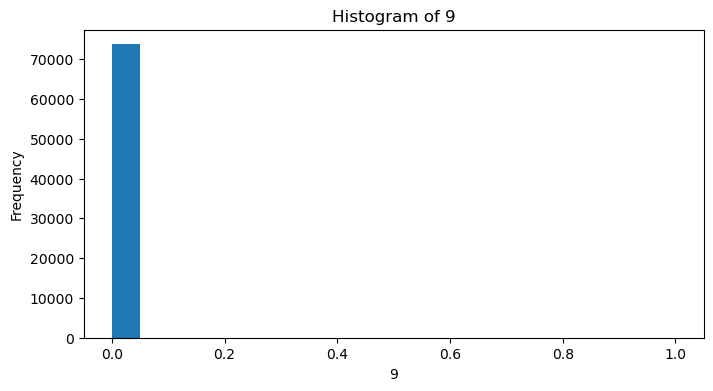

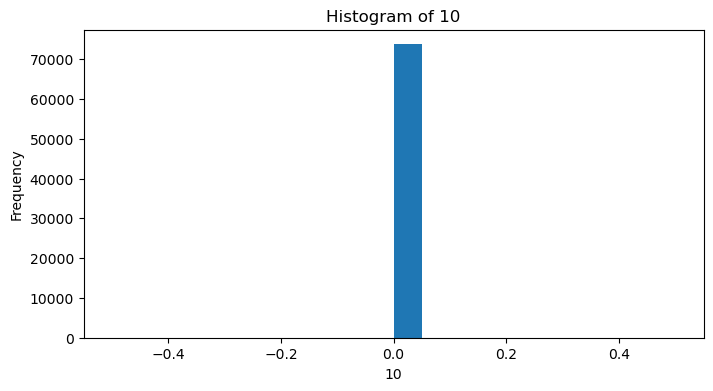

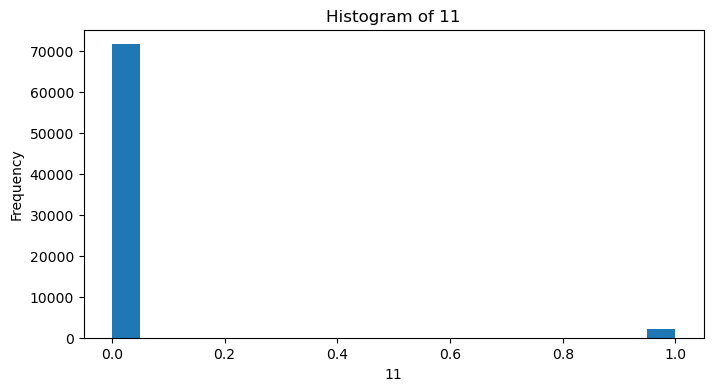

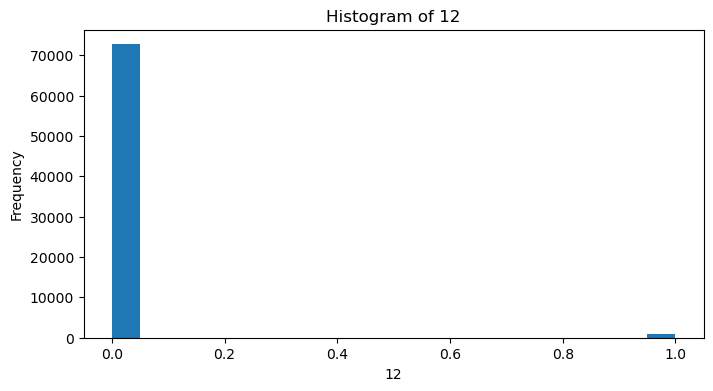

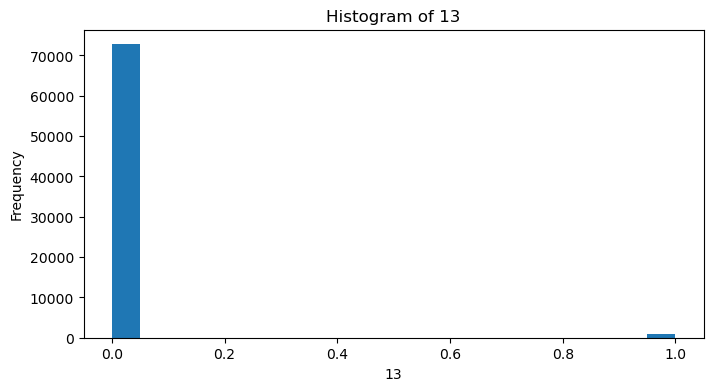

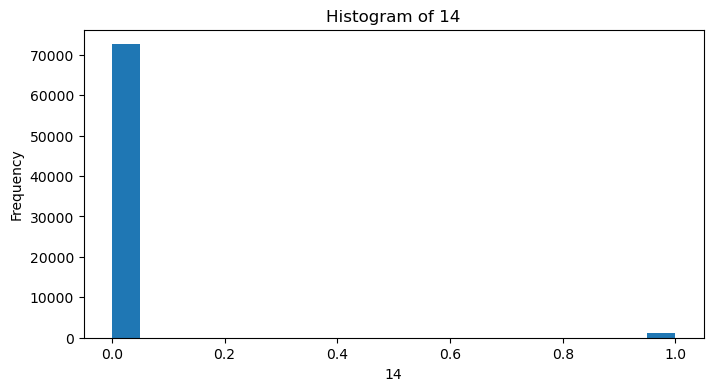

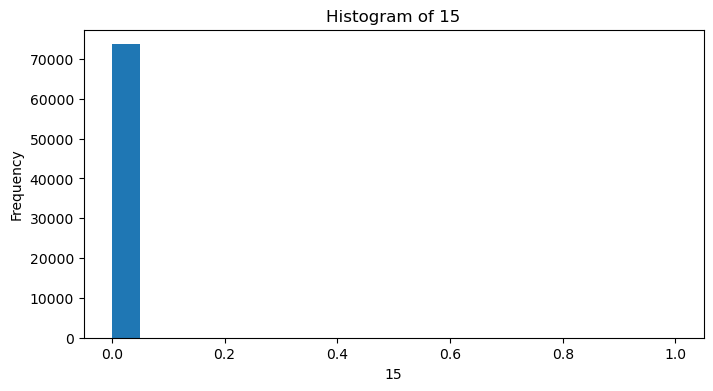

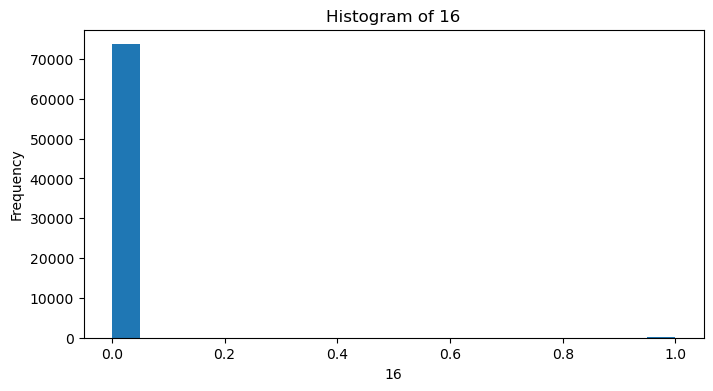

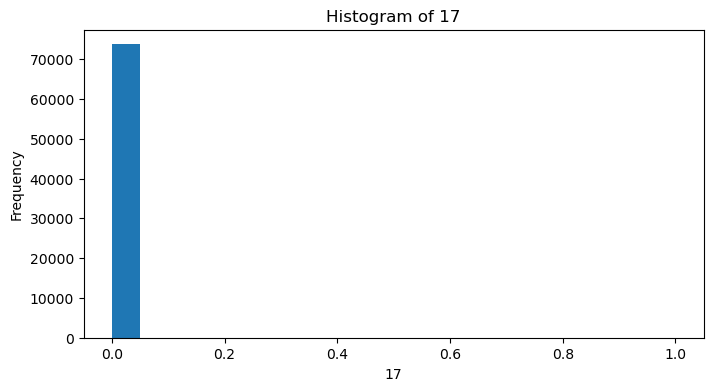

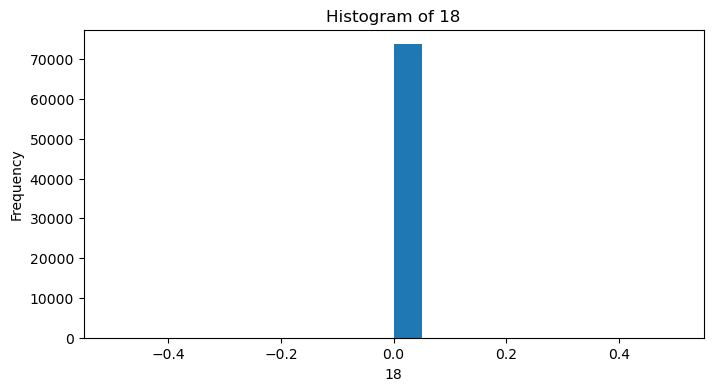

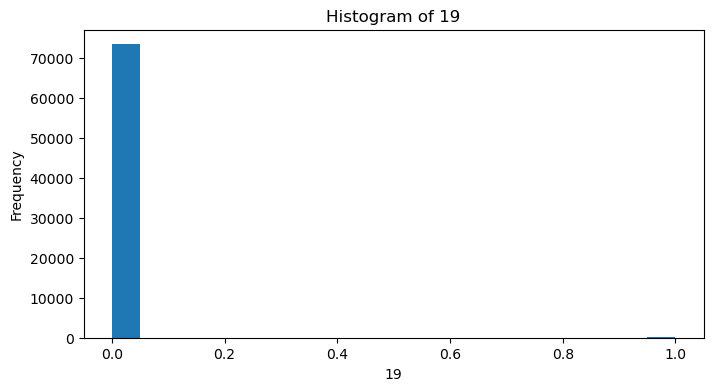

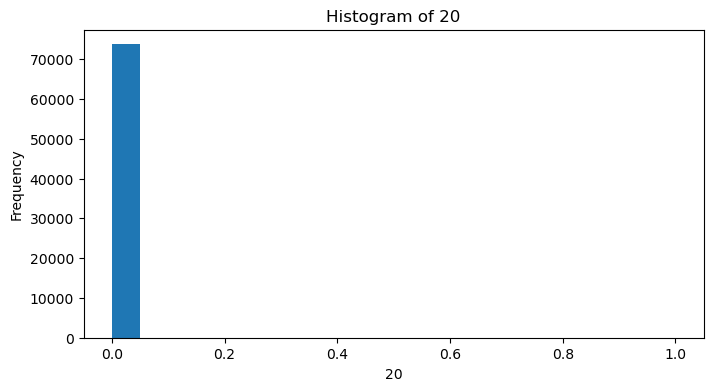

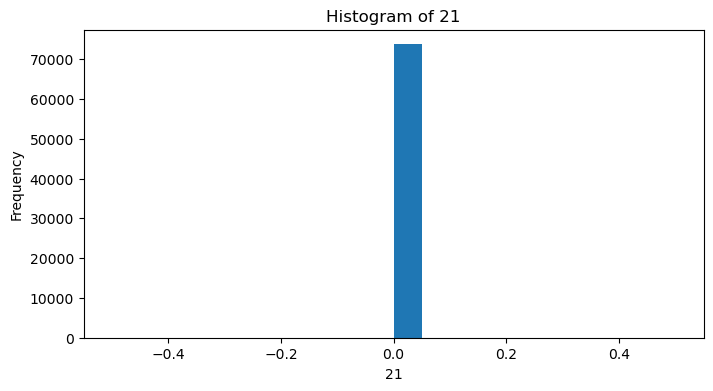

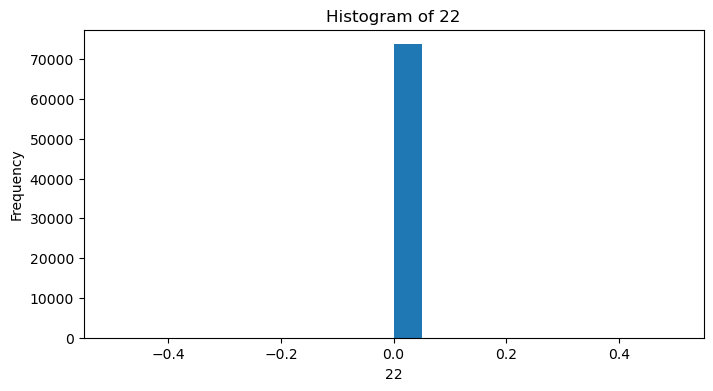

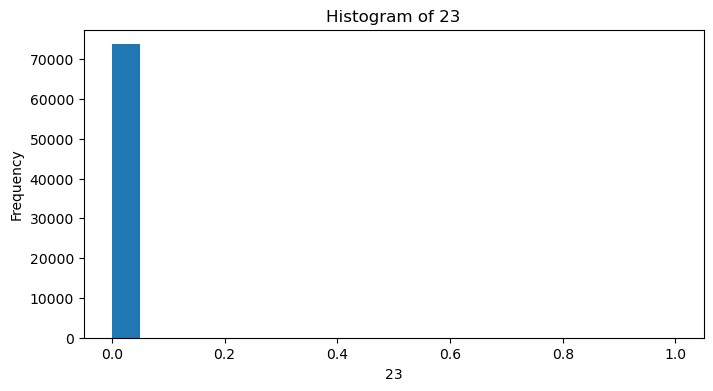

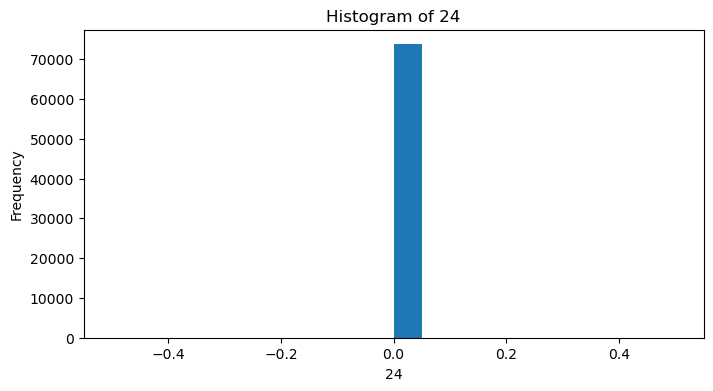

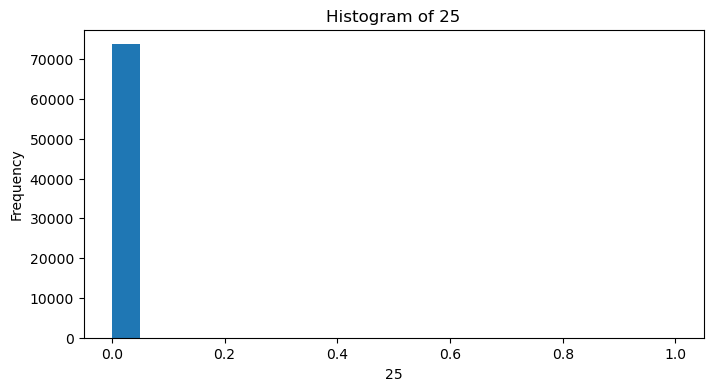

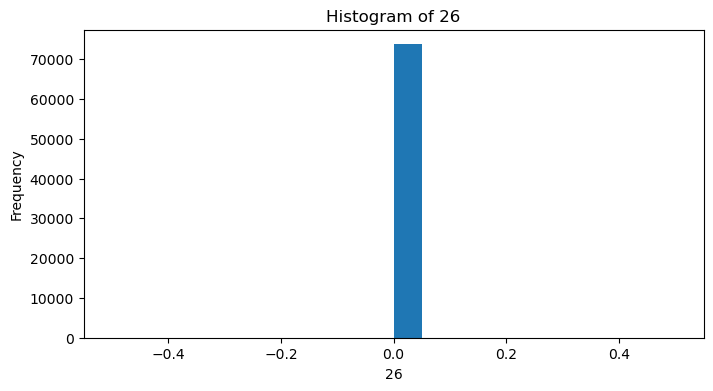

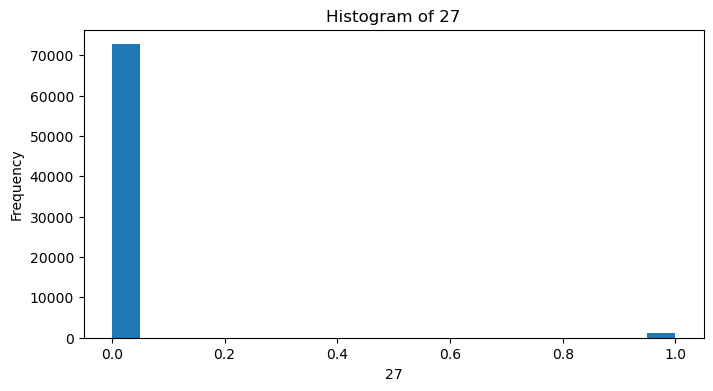

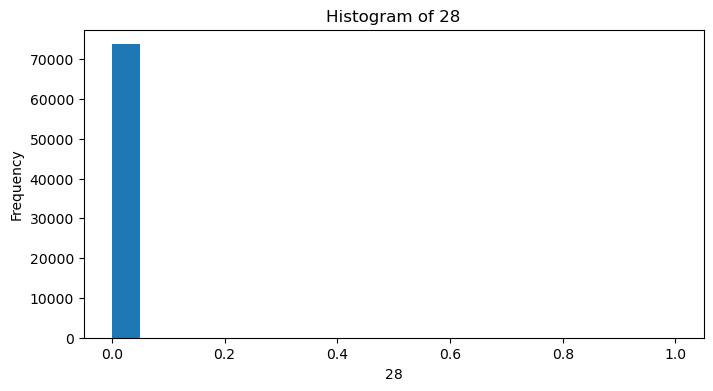

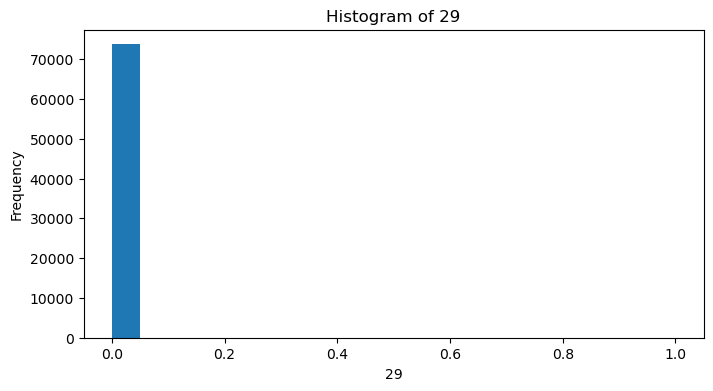

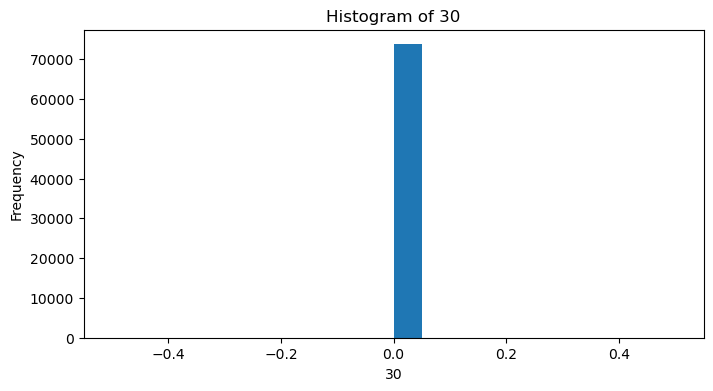

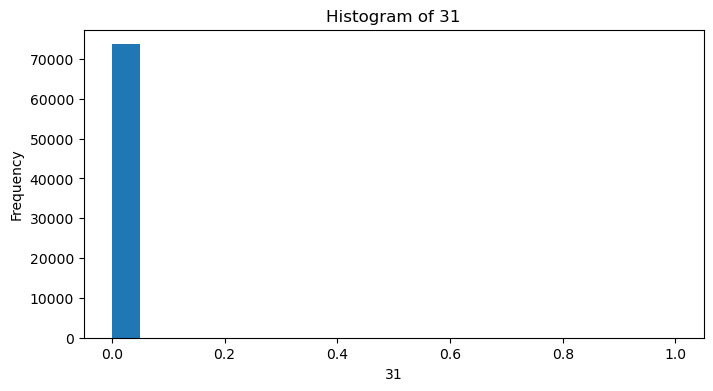

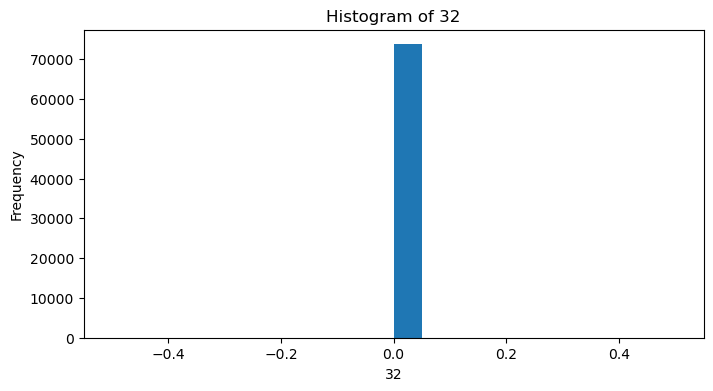

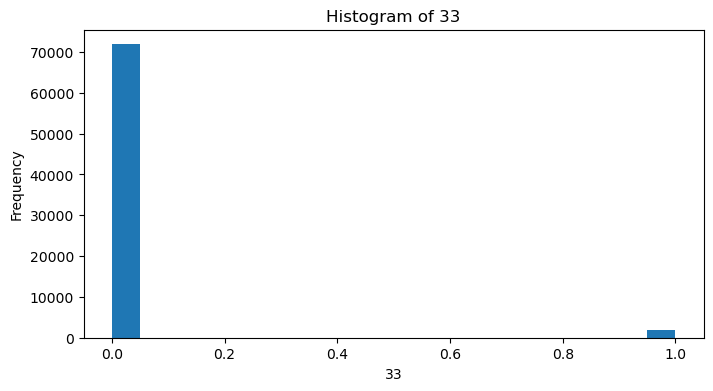

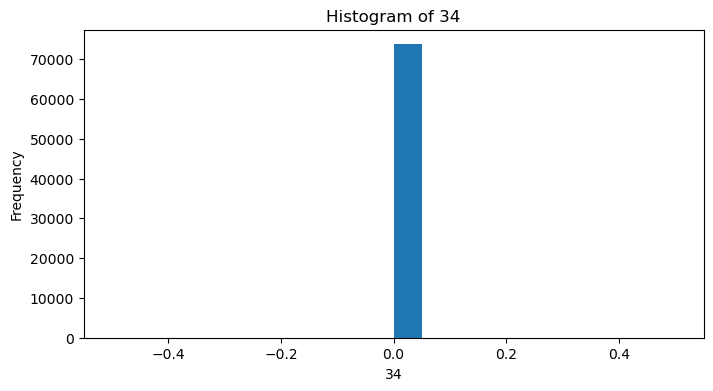

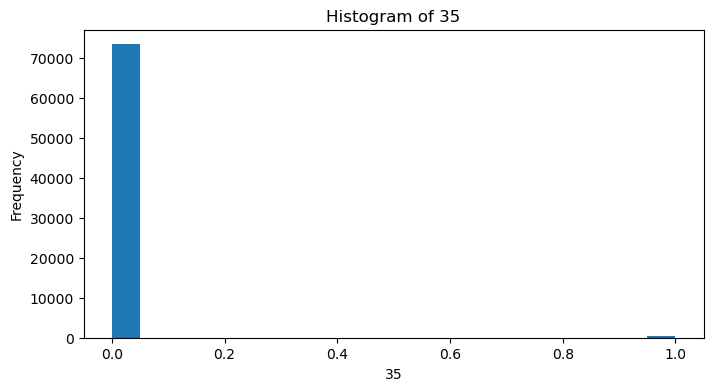

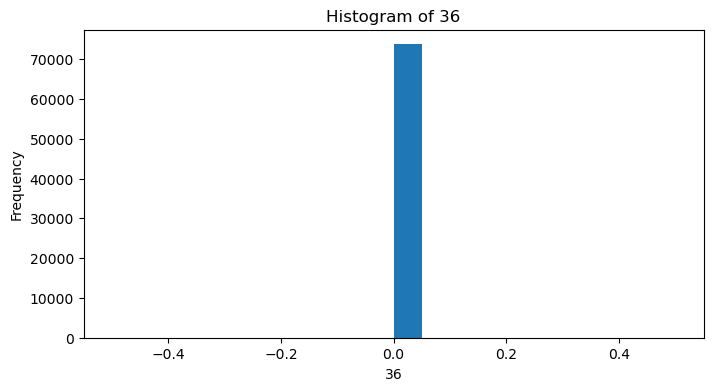

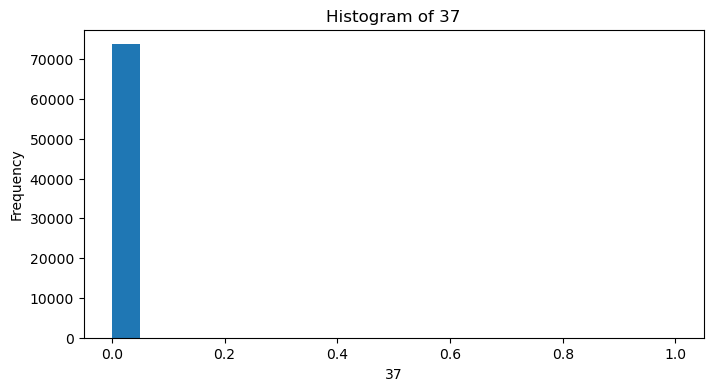

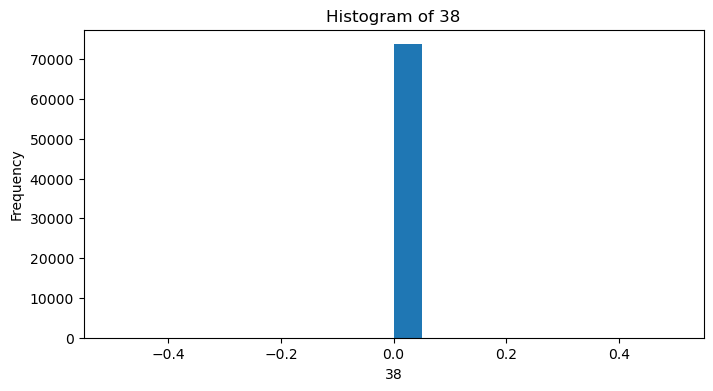

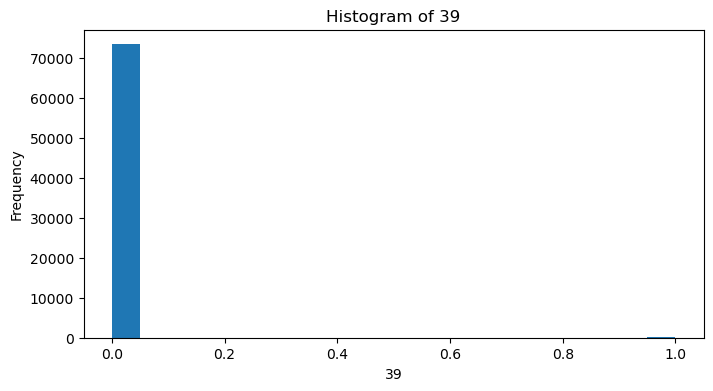

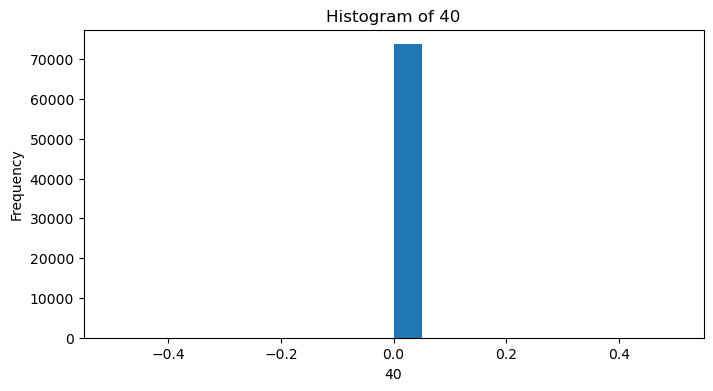

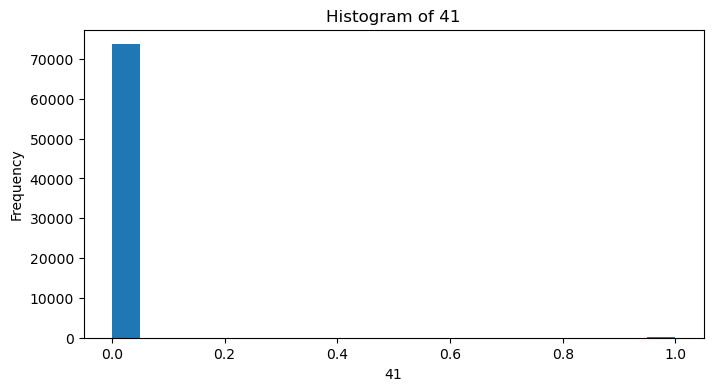

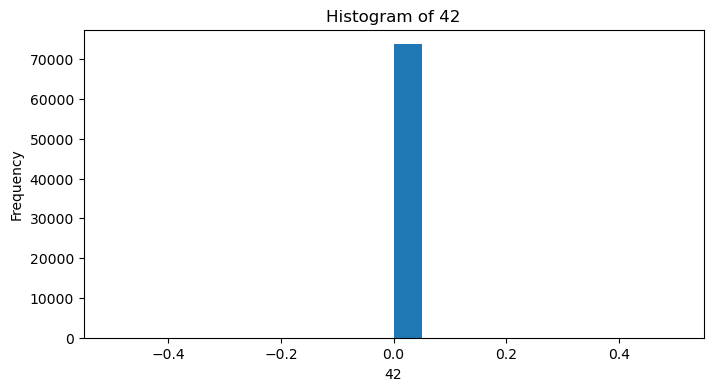

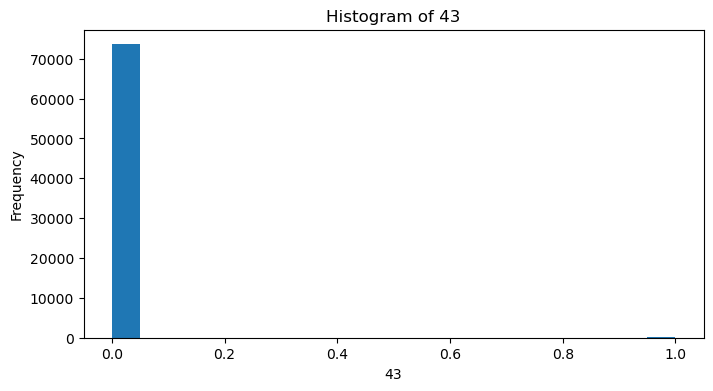

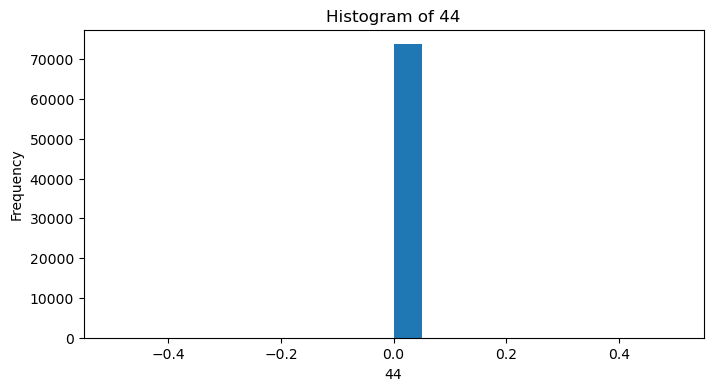

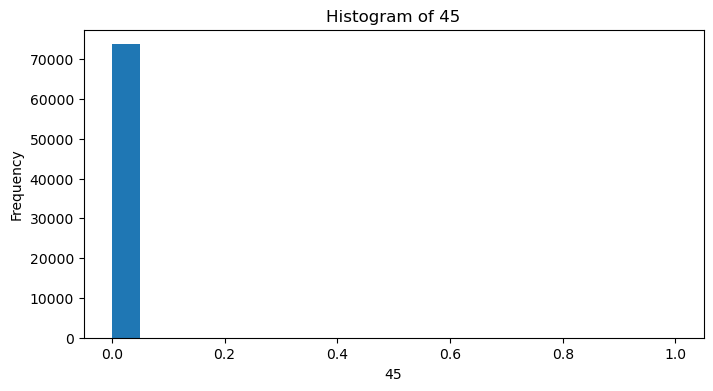

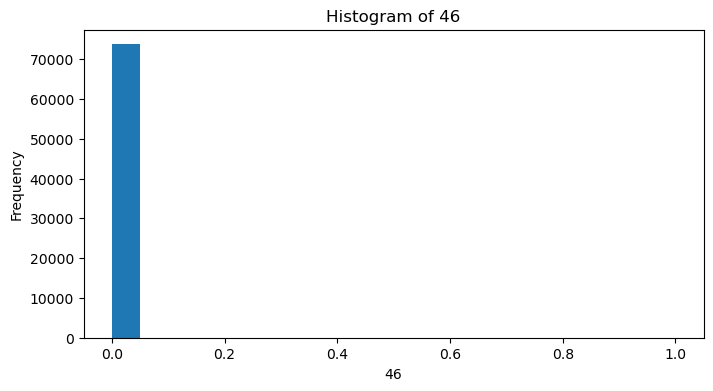

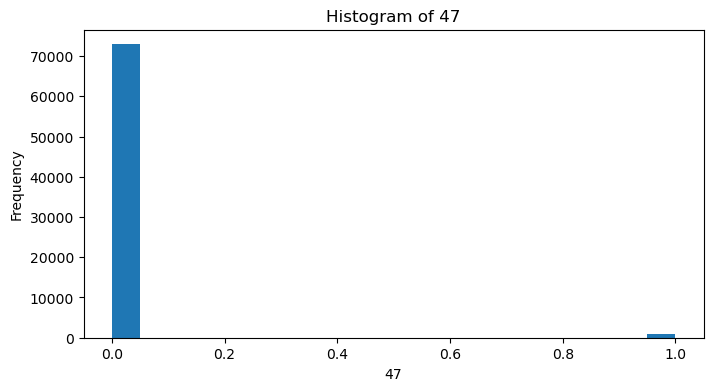

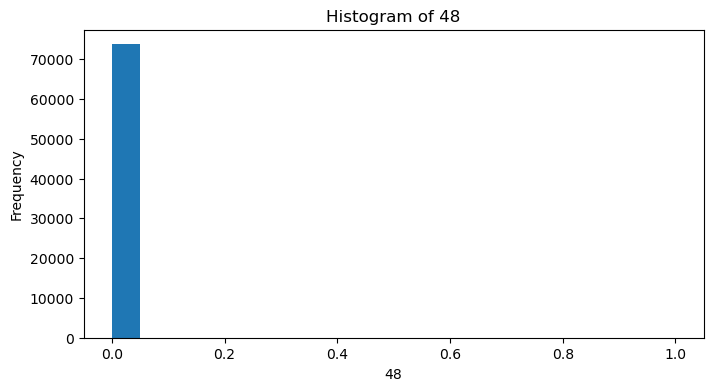

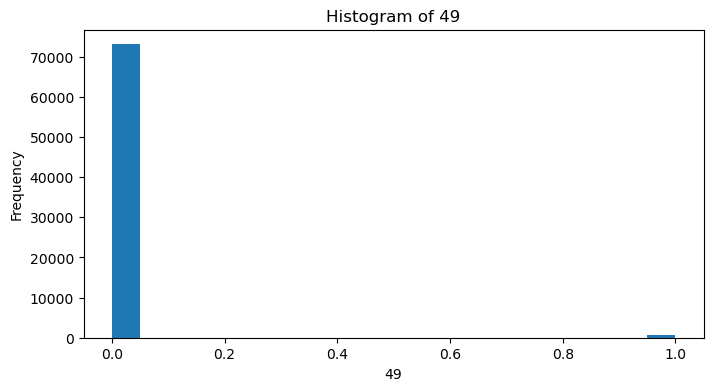

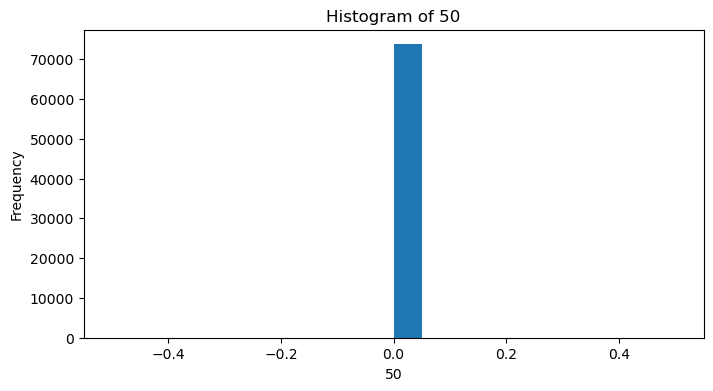

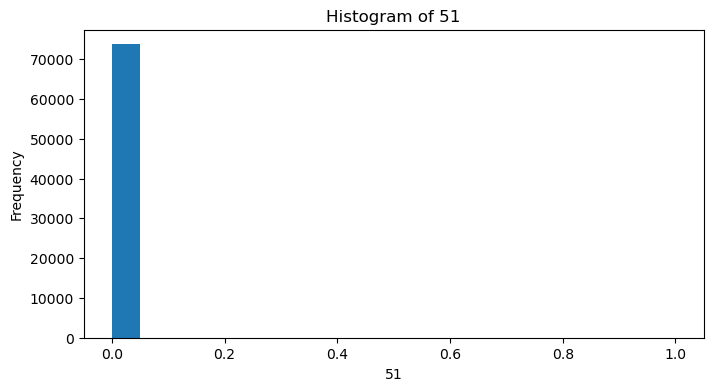

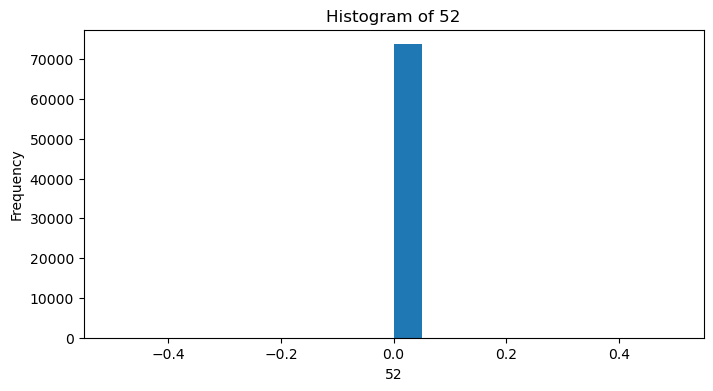

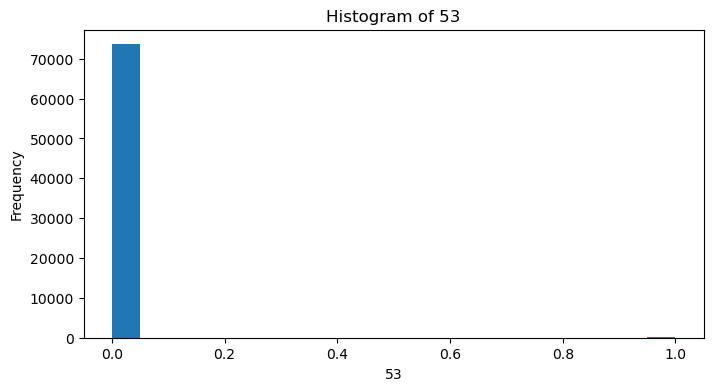

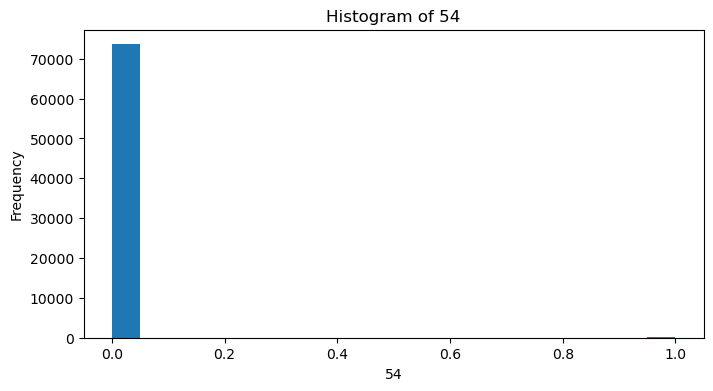

C:\Users\shiva\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


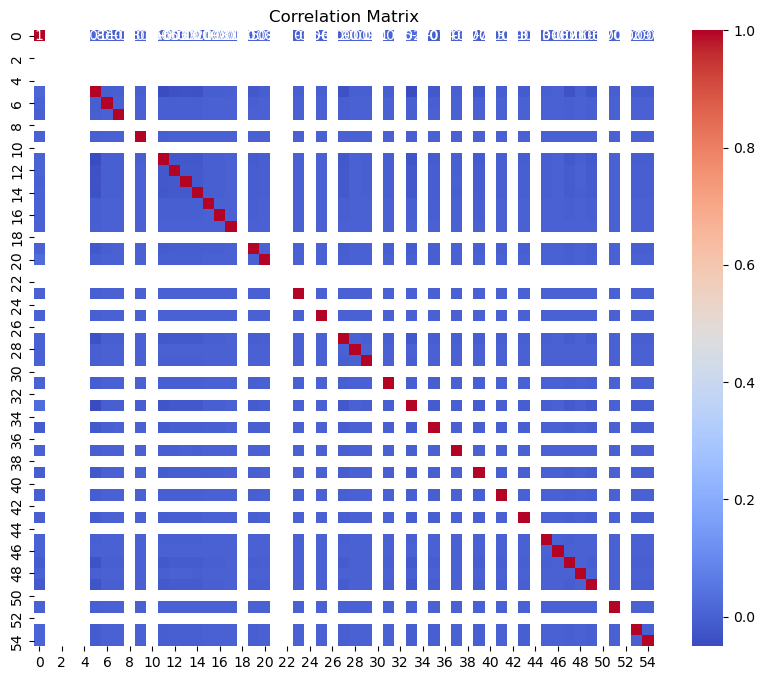

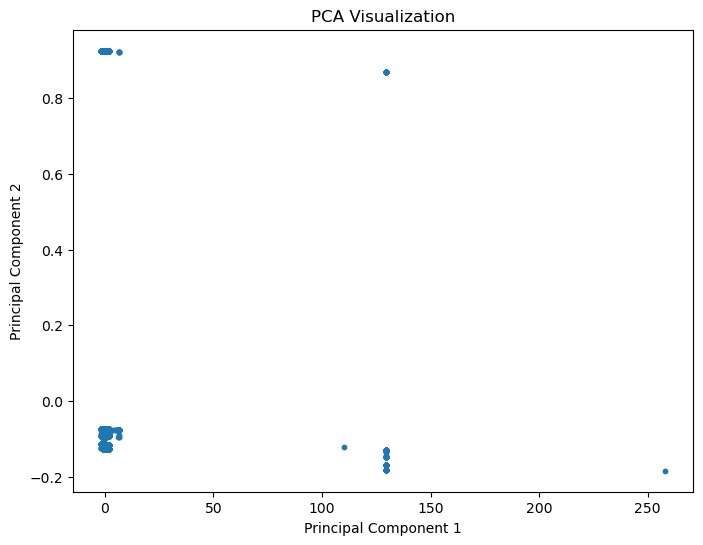

C:\Users\shiva\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


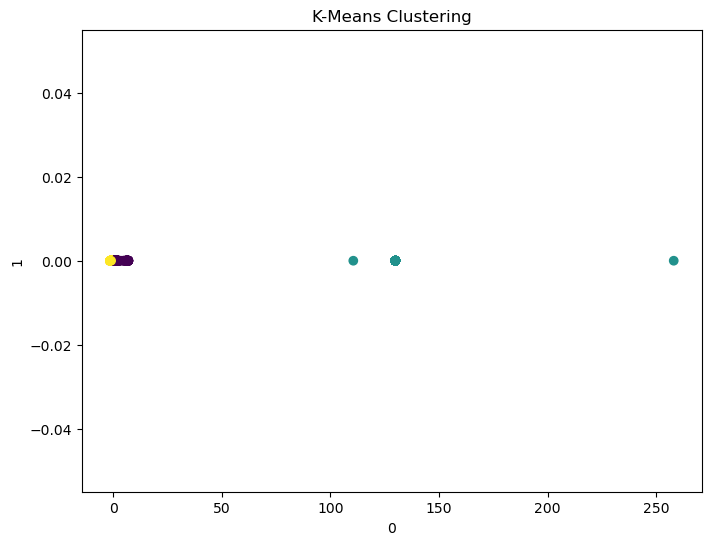


Feature importances:
0     2.012846
5     0.194321
11    0.177515
33    0.115383
12    0.094661
27    0.090485
47    0.073438
19    0.038808
14    0.028469
49    0.025247
43    0.017186
13    0.017002
39    0.016472
15    0.007871
20    0.007555
53    0.006724
54    0.006106
16    0.005680
41    0.005073
6     0.003754
7     0.003390
45    0.002708
31    0.002346
29    0.002239
48    0.001751
37    0.001654
9     0.001437
51    0.000563
23    0.000521
25    0.000481
17    0.000444
28    0.000385
46    0.000135
50    0.000000
3     0.000000
52    0.000000
10    0.000000
8     0.000000
44    0.000000
4     0.000000
42    0.000000
18    0.000000
40    0.000000
38    0.000000
21    0.000000
36    0.000000
35    0.000000
34    0.000000
2     0.000000
32    0.000000
1     0.000000
26    0.000000
24    0.000000
22    0.000000
30    0.000000
dtype: float64


In [7]:
# 3.msl_test.csv --> msl_test_labels.csv
process_file("msl_test.csv", "msl_test_label.csv")


Processing psm_test.csv and psm_test_label.csv...


C:\Users\shiva\AppData\Local\Temp\ipykernel_19192\2081568042.py:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('time_series_plot.svg', format='svg', bbox_inches='tight')


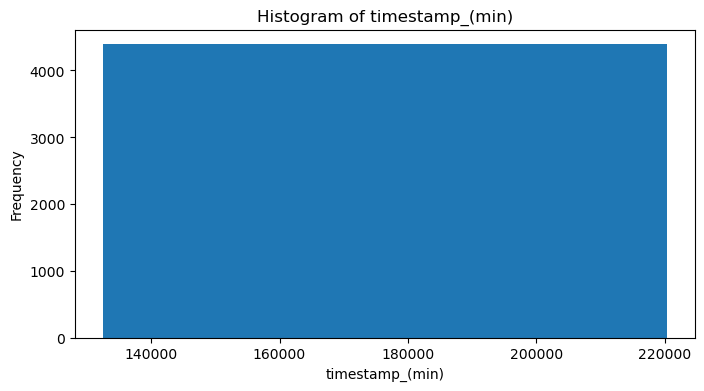

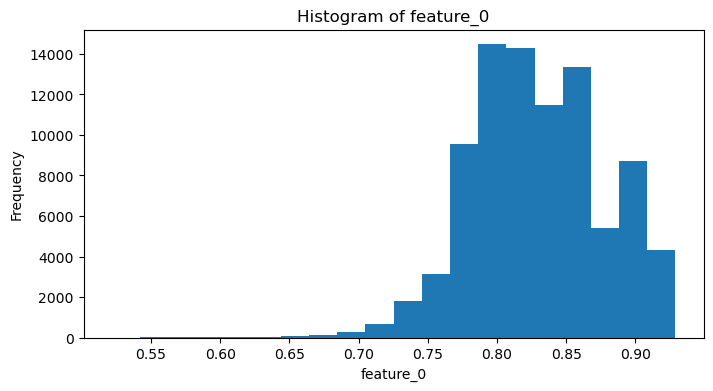

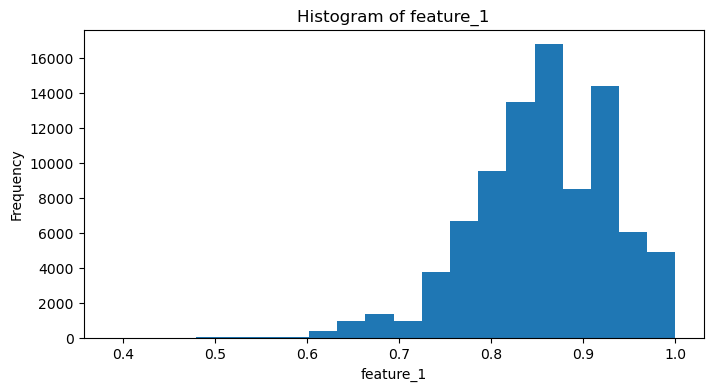

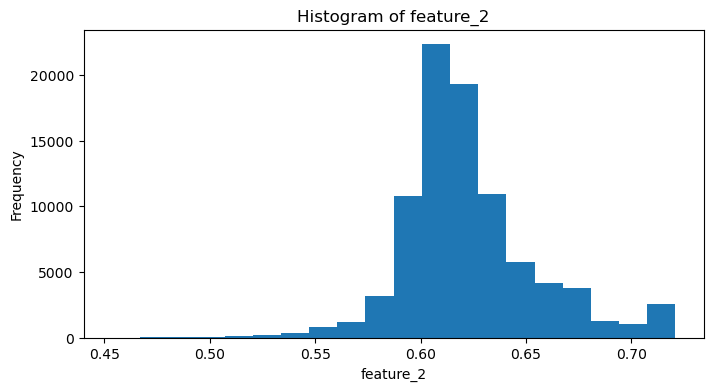

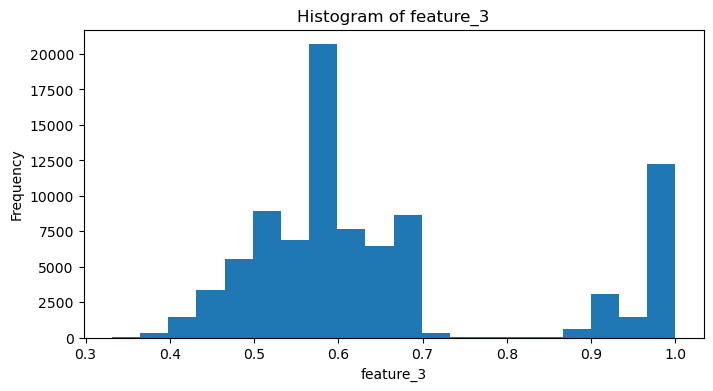

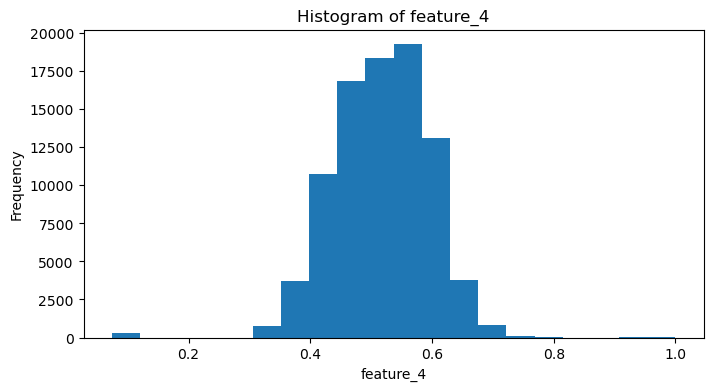

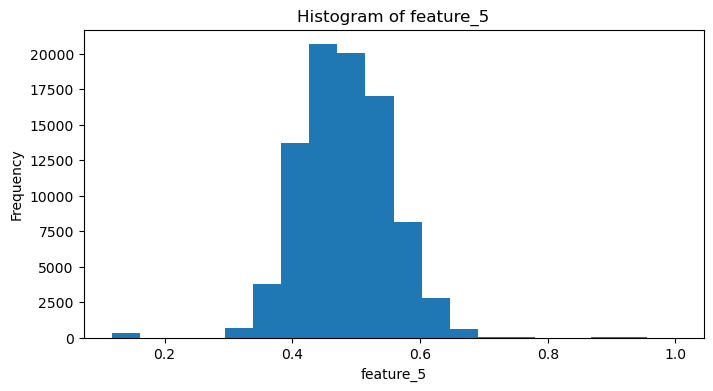

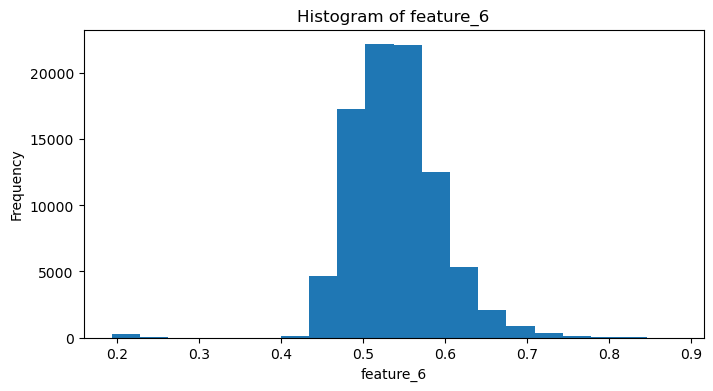

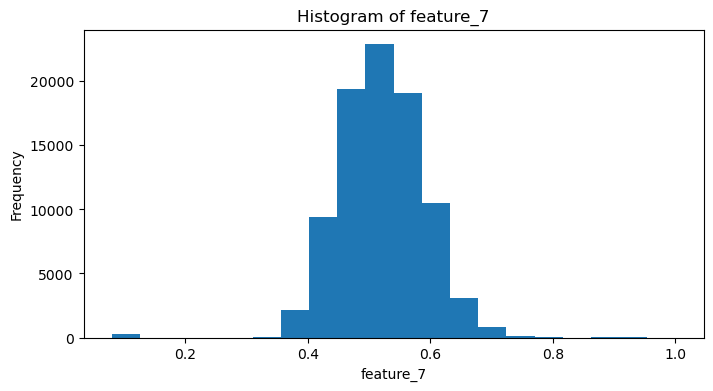

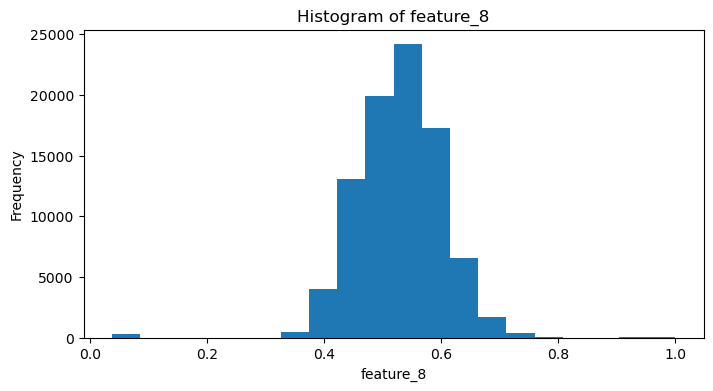

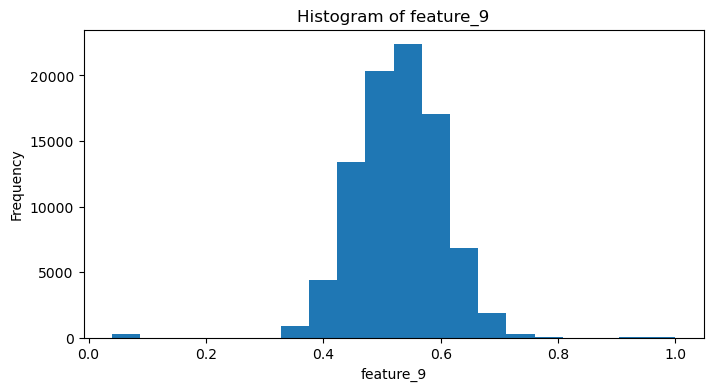

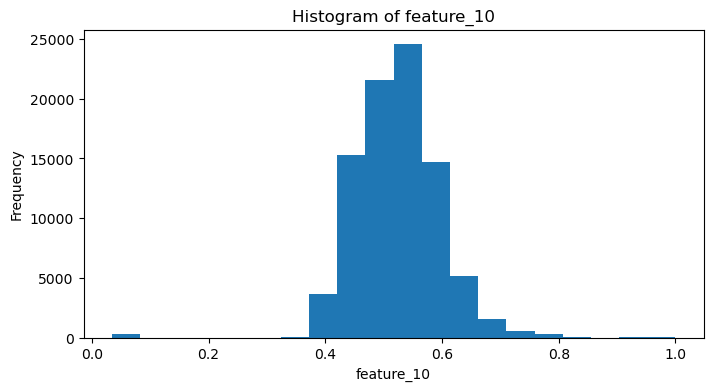

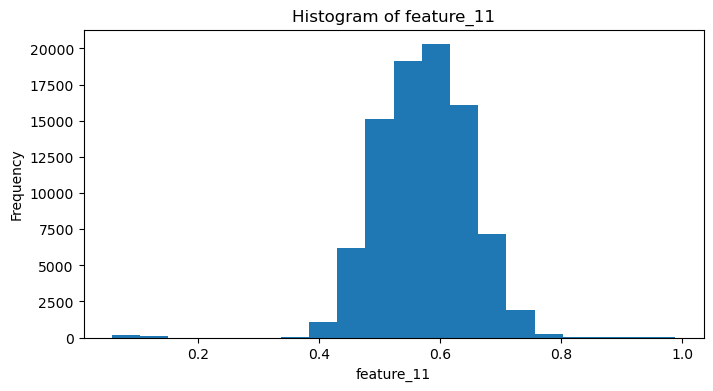

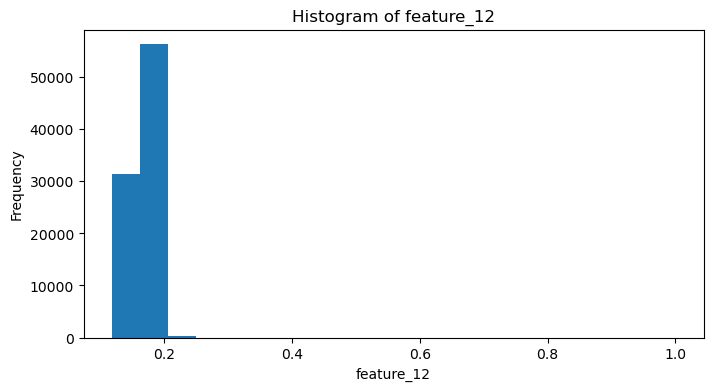

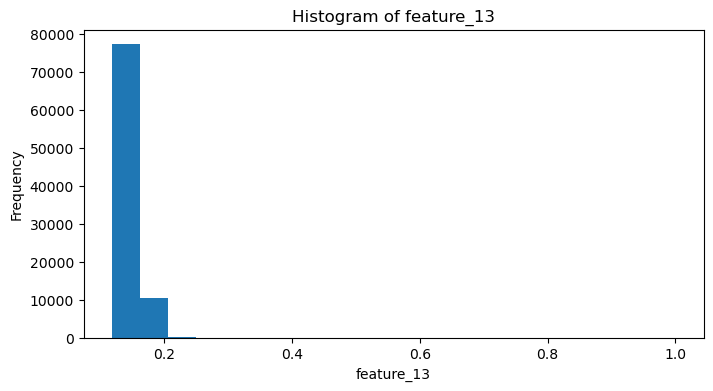

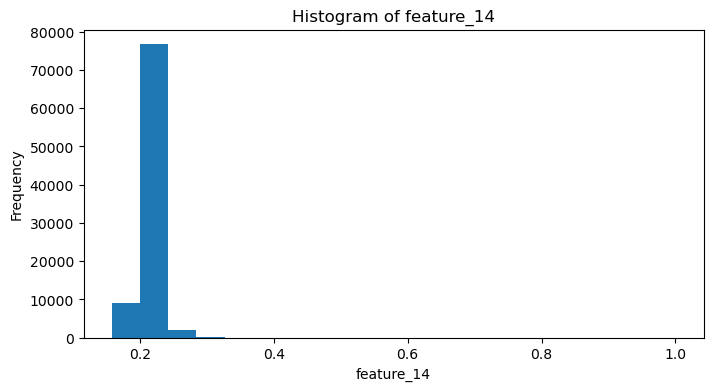

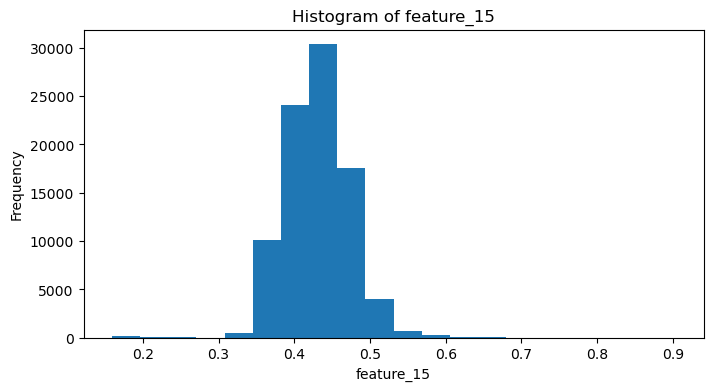

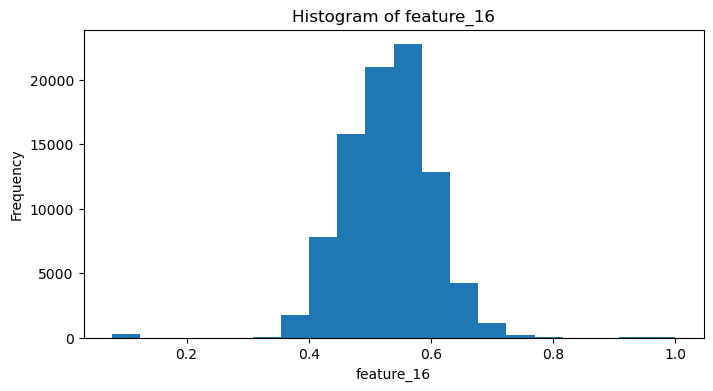

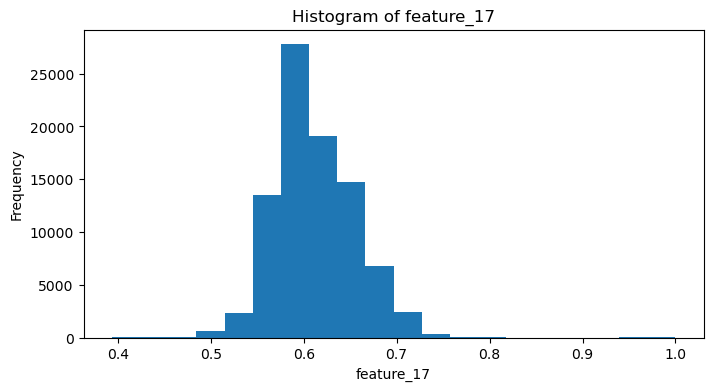

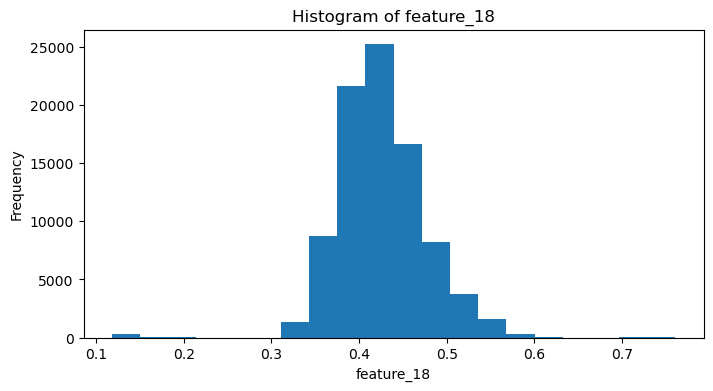

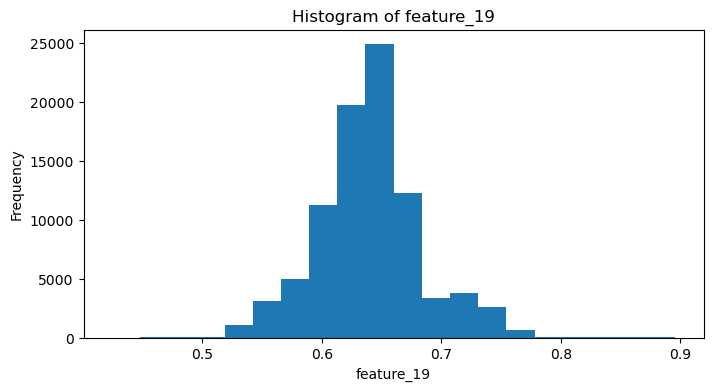

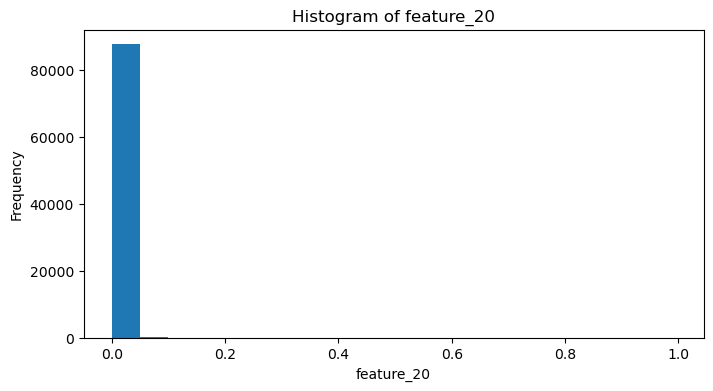

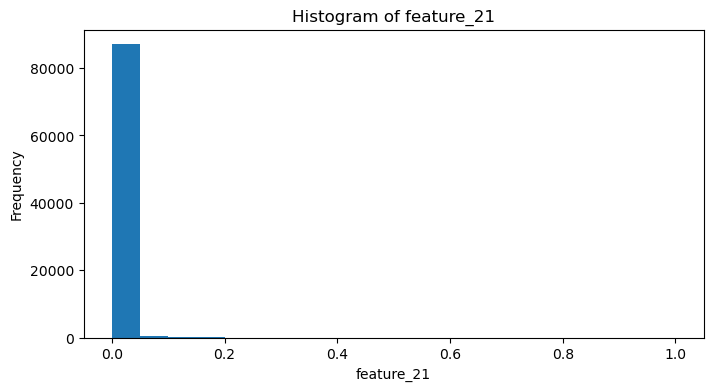

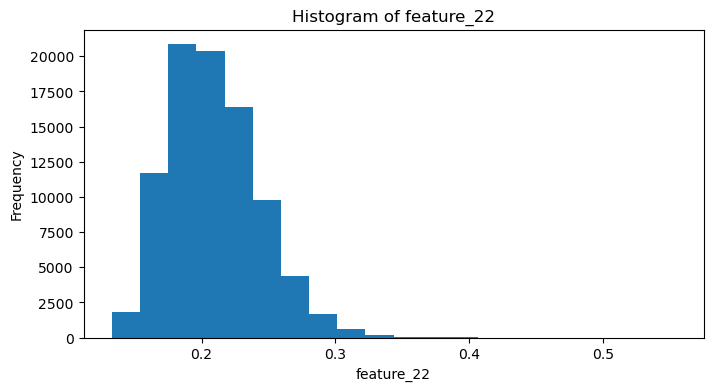

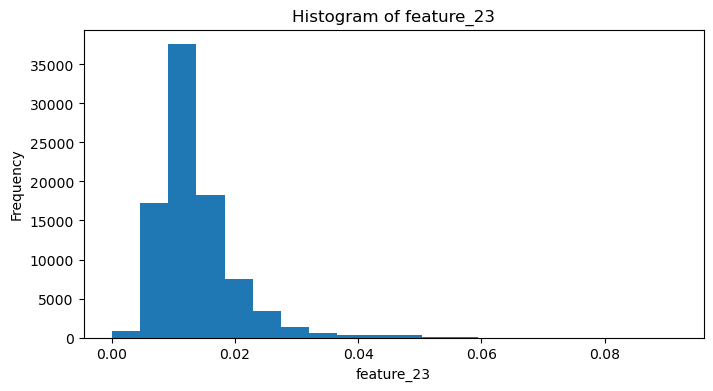

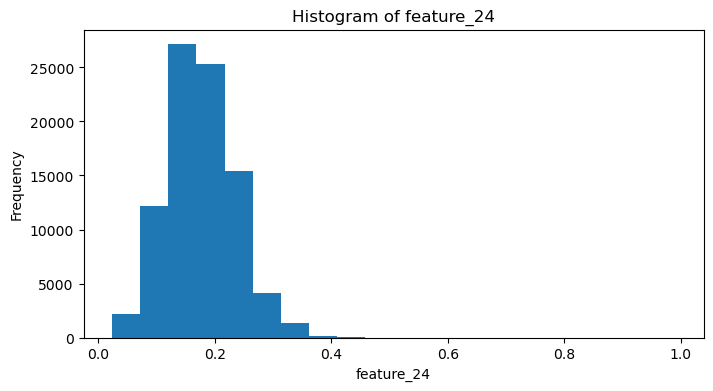

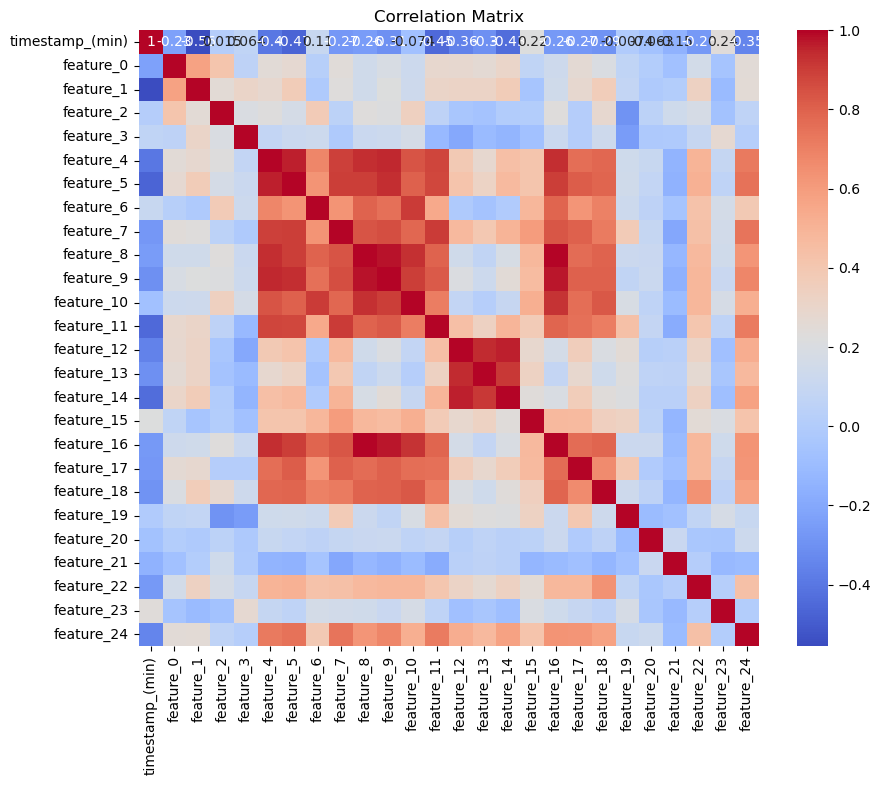

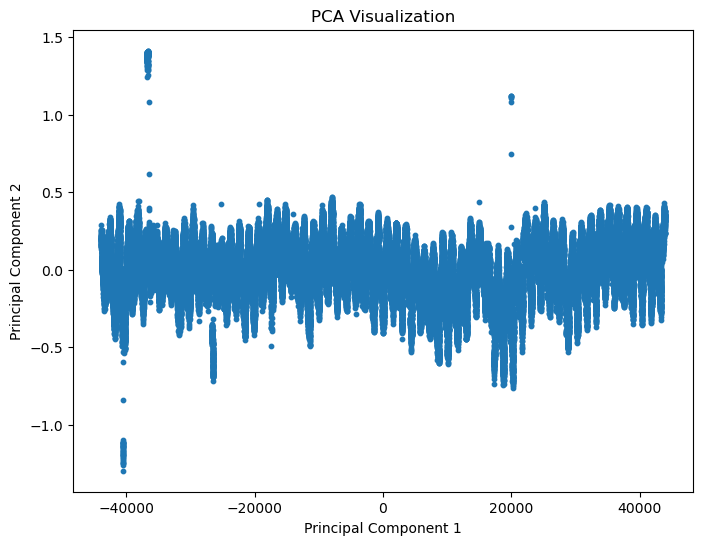

C:\Users\shiva\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


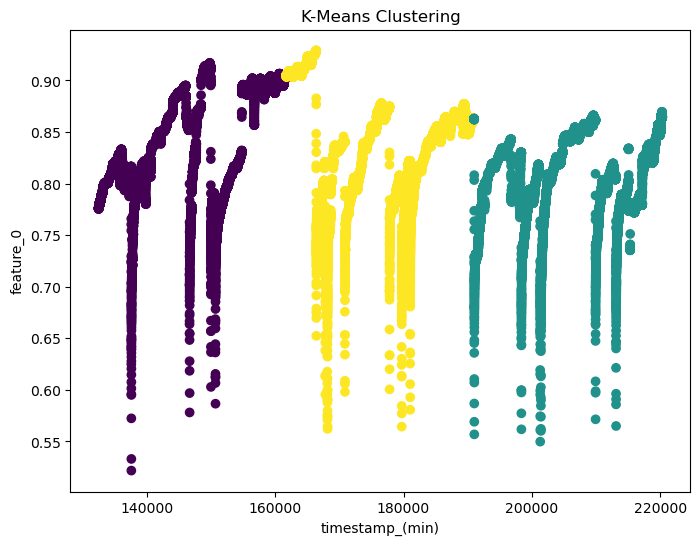


Feature importances:
feature_24         0.904130
feature_22         0.662584
feature_7          0.608785
feature_6          0.586236
feature_12         0.509348
feature_17         0.436739
feature_14         0.432999
feature_18         0.406352
feature_11         0.399925
timestamp_(min)    0.353329
feature_13         0.326825
feature_10         0.312139
feature_15         0.288062
feature_1          0.271015
feature_0          0.262223
feature_4          0.251562
feature_5          0.230379
feature_3          0.218151
feature_19         0.189869
feature_2          0.165921
feature_9          0.158447
feature_16         0.138078
feature_8          0.093226
feature_20         0.062672
feature_21         0.052264
feature_23         0.030720
dtype: float64


In [30]:
# 4.psm_test.csv --> psm_test_labels.csv
process_file("psm_test.csv", "psm_test_label.csv")